In [77]:
!pip install tensorflow-addons

In [78]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


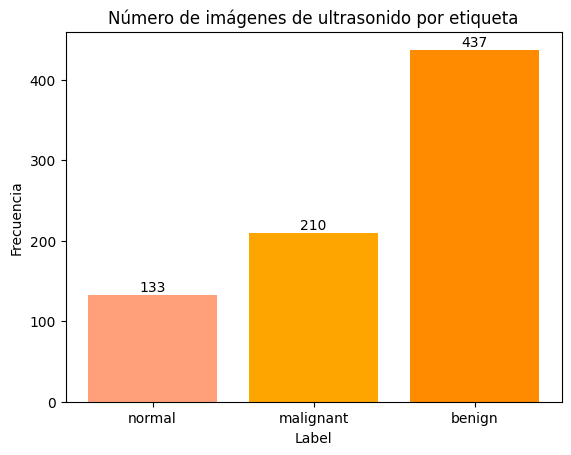

<built-in method items of dict object at 0x7b6957e99e80>


In [79]:
## Avance 1 de proyecto
## Título: Comparación de algoritmos de segmentación para la detección de cáncer de mama a partir de imágenes de ultrasonido
## Autores: Alessandra Mercedes Aldave Javier, Valeria Oriana Zavaleta Jave


# Importación de librerías
import os
import glob
import matplotlib.pyplot as plt
from collections import Counter
import cv2
import random
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


#Paths en google drive
normal_path = "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal"
malignant_path = "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant"
benign_path = "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign"


# Paths de la ubicación de cada carpeta de datos
#normal_path = r"C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Avance1\Dataset_BUSI_with_GT\normal"
#malignant_path = r"C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Avance1\Dataset_BUSI_with_GT\malignant"
#benign_path = r"C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Avance1\Dataset_BUSI_with_GT\benign"


# Función para cargar dataset de imágenes
    # Se usara un diccionario para guardar el path correspondiente a una imagen x (como key), y como value se tendra una lista cuyos elementos son: la etiqueta de esa imagen x, y el path de la mascara de la imagen x (lo mismo para todas las imagenes)
def CargarImagenesYMascaras(path_de_file):
    dataset = {} # Creación del diccionario
    for path_de_imagen in glob.glob(os.path.join(path_de_file, '*.png')):
        filename = os.path.basename(path_de_imagen)
        label = filename.split('(')[0].strip()
        if "_mask" not in filename:
            mask_path = os.path.join(path_de_file, filename.replace('.png', '_mask.png'))
            if os.path.exists(mask_path):
                dataset[path_de_imagen] = [label, mask_path]
    return dataset

# Cargar paths de imágenes de ultrasonido con su respectivo label y path de imagenes de mascaras
dataset = {}
dataset.update(CargarImagenesYMascaras(normal_path))
dataset.update(CargarImagenesYMascaras(malignant_path))
dataset.update(CargarImagenesYMascaras(benign_path))

# Determinación de la cantidad de imagenes de ultrasonido de cada tipo (o de cada label)
diccionario_conteo_labels = Counter(label for label,_ in dataset.values())

# Gráfico de barras
barras = plt.bar(diccionario_conteo_labels.keys(), diccionario_conteo_labels.values(), color= ['#FFA07A', '#FFA500', '#FF8C00'])
plt.xlabel('Label')
plt.ylabel('Frecuencia')
plt.title('Número de imágenes de ultrasonido por etiqueta')

for barra_label in barras:
    altura = barra_label.get_height()
    plt.text(barra_label.get_x() + barra_label.get_width() / 2, altura, altura, ha='center', va='bottom')

plt.show()
print(dataset.items)

In [80]:
def dividir_dataset_por_clase(dataset, train_ratio=0.75):
    train_set = {}
    test_set = {}

    # Separar por clases
    clases = {'normal': [], 'benign': [], 'malignant': []}
    for path, (label, mask_path) in dataset.items():
        clases[label].append((path, (label, mask_path)))

    # Dividir cada clase
    for label, items in clases.items():
        random.shuffle(items)
        train_size = int(len(items) * train_ratio)
        train_items = items[:train_size]
        test_items = items[train_size:]

        # Añadir al conjunto de entrenamiento y prueba
        train_set.update(train_items)
        test_set.update(test_items)

    return train_set, test_set

# Aplicar la función para dividir el dataset
train_set, test_set = dividir_dataset_por_clase(dataset)

Imágenes de ultrasonido normales:
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (21).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (45).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (77).png


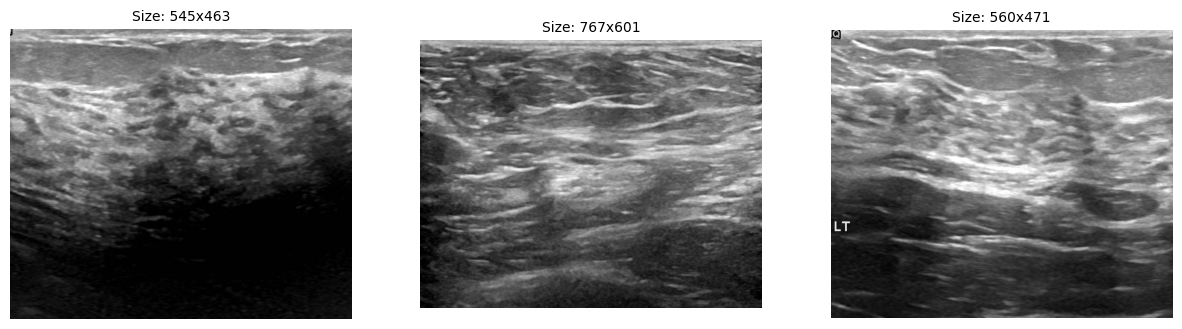


Imágenes de ultrasonido benignas:
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (316).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (427).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (368).png


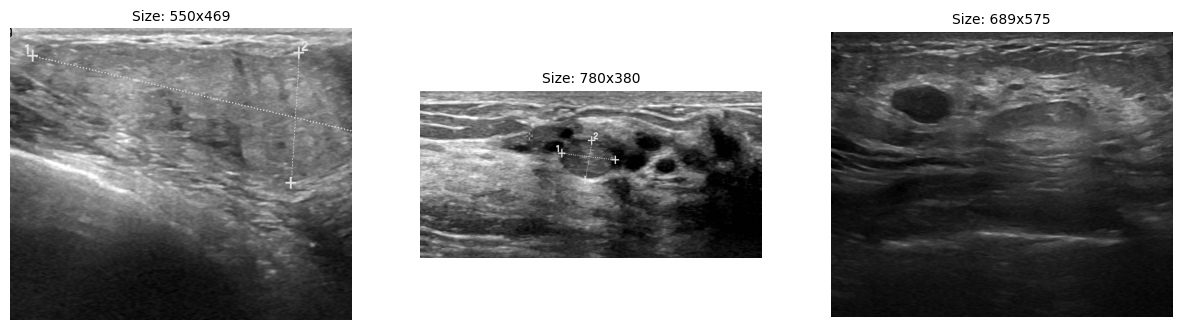


Imágenes de ultrasonido malignas:
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (22).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (63).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (145).png


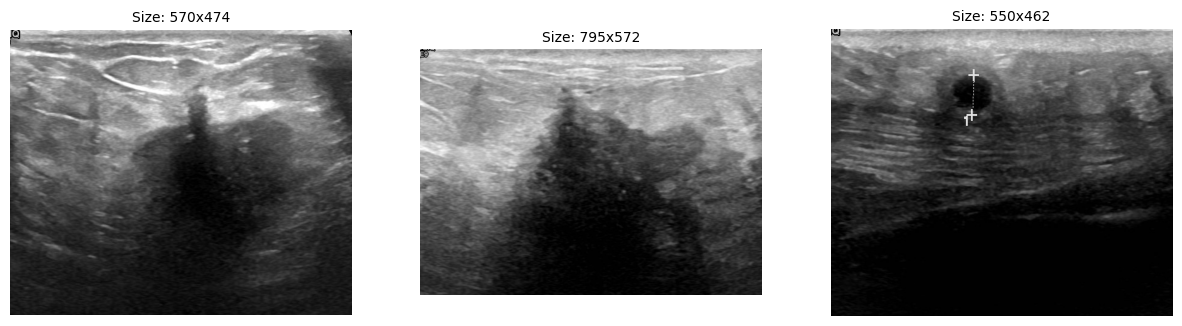

In [81]:
# Muestra de las primeras tres images de cada etiqueta del dataset
def Mostrar3Imagenes(image_paths):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, image_path in enumerate(image_paths):
        if i < len(axes):
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i].imshow(image_rgb)
            axes[i].axis('off')

            # Características de la imagen
            propiedades_imagenes = f"Size: {image.shape[1]}x{image.shape[0]}"
            axes[i].set_title(propiedades_imagenes, fontsize=10)

            # Path de las imagenes
            print(image_path)
    plt.show()

# Seleccion de 3 imagenes de cada categoria sin tomar en cuenta las mascaras
normal_images = random.sample([path for path, (label, _) in dataset.items() if label == 'normal'], 3)
benign_images = random.sample([path for path, (label, _) in dataset.items() if label == 'benign'], 3)
malignant_images = random.sample([path for path, (label, _) in dataset.items() if label == 'malignant'], 3)

print("Imágenes de ultrasonido normales:")
Mostrar3Imagenes(normal_images)
print("\nImágenes de ultrasonido benignas:")
Mostrar3Imagenes(benign_images)
print("\nImágenes de ultrasonido malignas:")
Mostrar3Imagenes(malignant_images)

In [82]:
# Transformaciones de Augmentations
from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate, Perspective, Resize, Normalize
from albumentations.pytorch import ToTensorV2

In [83]:
# Definir transformaciones de datos
transform = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Rotate(limit=15, p=0.5),
    Resize(224, 224),
    ToTensorV2()
])

In [84]:
# Función para aplicar transformaciones a una imagen y su máscara
def apply_transforms(image, mask):
    transformed = transform(image=image, mask=mask)
    transformed_image = transformed['image']
    transformed_mask = transformed['mask']
    return transformed_image, transformed_mask

In [85]:
# Seleccionar el 25% de las imágenes y máscaras para aumentar
augmentation_samples = random.sample(list(train_set.items()), int(len(train_set) * 0.25))

In [86]:
import os

# Definir los paths de las carpetas de transformación
transformed_paths = {
    'normal': "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed",
    'malignant': "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed",
    'benign': "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed"
}

In [87]:
# Verificar si las carpetas de transformación existen, si no, crearlas
for path in transformed_paths.values():
    if not os.path.exists(path):
        os.makedirs(path)

In [88]:
transformed_samples = {}
# Aplicar aumento de datos y actualizar el conjunto de entrenamiento
for image_path, (label, mask_path) in augmentation_samples:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    transformed_image, transformed_mask = apply_transforms(image, mask)

    # Convertir tensores PyTorch a matrices NumPy
    transformed_image = (transformed_image.permute(1, 2, 0).numpy()).astype(np.uint8)
    transformed_mask = transformed_mask.squeeze().numpy().astype(np.uint8)

    # Guardar las imágenes y las máscaras transformadas en las carpetas correspondientes
    transformed_image_path = os.path.join(transformed_paths[label], f"transformed_{os.path.basename(image_path)}")
    transformed_mask_path = os.path.join(transformed_paths[label], f"transformed_{os.path.basename(mask_path)}")

    cv2.imwrite(transformed_image_path, transformed_image)
    cv2.imwrite(transformed_mask_path, transformed_mask)

    # Agregar las transformaciones al conjunto de entrenamiento
    train_set[transformed_image_path] = (label, transformed_mask_path)

    # Agregar la imagen y la máscara transformadas al diccionario
    transformed_samples[transformed_image_path] = (label, transformed_mask_path)

# Actualizar el tamaño del conjunto de entrenamiento
train_set_size = len(train_set)
print("Tamaño del conjunto de entrenamiento después del aumento de datos:", train_set_size)

Tamaño del conjunto de entrenamiento después del aumento de datos: 728


Transformed image: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (136).png
Original image: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (136).png
Transformed mask: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (136)_mask.png
Original mask: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (136)_mask.png
Transformed image: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (119).png
Original image: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (119).png
Transformed mask: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (119)_mask.png
Original mask: /con

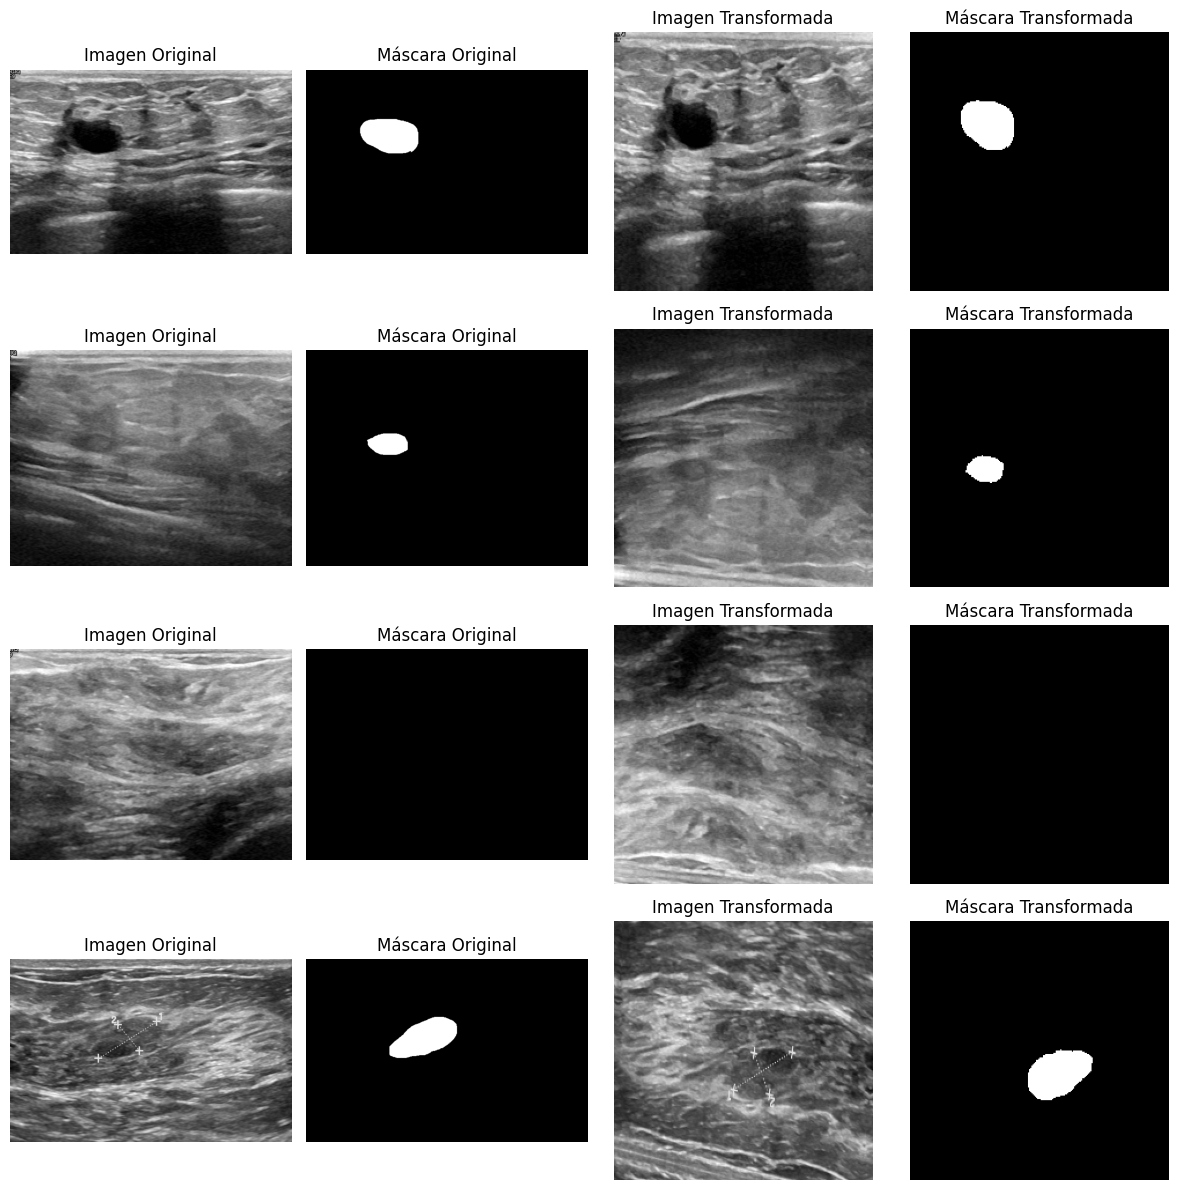

In [89]:
# Función para mostrar imágenes y máscaras transformadas y originales
def show_transformed_and_original_images(transformed_samples):
    # Seleccionar aleatoriamente 4 imágenes transformadas
    selected_images = random.sample(list(transformed_samples.items()), 4)

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, (transformed_image_path, (label, transformed_mask_path)) in enumerate(selected_images):
        # Cargar imágenes y máscaras transformadas
        transformed_image = cv2.imread(transformed_image_path)
        transformed_mask = cv2.imread(transformed_mask_path, cv2.IMREAD_GRAYSCALE)

        # Generar los paths correspondientes a las imágenes y máscaras originales
        original_image_filename = os.path.basename(transformed_image_path).replace("transformed_", "")
        original_mask_filename = os.path.basename(transformed_mask_path).replace("transformed_", "")

        # Construir los paths completos para las imágenes y máscaras originales
        original_image_path = os.path.join(os.path.dirname(os.path.dirname(transformed_image_path)), label, original_image_filename)
        original_mask_path = os.path.join(os.path.dirname(os.path.dirname(transformed_mask_path)), label, original_mask_filename)

        print(f"Transformed image: {transformed_image_path}")
        print(f"Original image: {original_image_path}")
        print(f"Transformed mask: {transformed_mask_path}")
        print(f"Original mask: {original_mask_path}")

        # Cargar imágenes originales y sus máscaras originales
        if os.path.exists(original_image_path) and os.path.exists(original_mask_path):
            original_image = cv2.imread(original_image_path)
            original_mask = cv2.imread(original_mask_path, cv2.IMREAD_GRAYSCALE)
        else:
            original_image = None
            original_mask = None

        # Mostrar imágenes y máscaras en el gráfico
        if original_image is not None and original_mask is not None:
            axes[i, 0].imshow(original_image, cmap='gray')
            axes[i, 0].set_title('Imagen Original')
            axes[i, 0].axis('off')
            axes[i, 1].imshow(original_mask, cmap='gray')
            axes[i, 1].set_title('Máscara Original')
            axes[i, 1].axis('off')
        else:
            axes[i, 0].text(0.5, 0.5, 'Imagen Original no encontrada', horizontalalignment='center', verticalalignment='center', transform=axes[i, 0].transAxes)
            axes[i, 1].text(0.5, 0.5, 'Máscara Original no encontrada', horizontalalignment='center', verticalalignment='center', transform=axes[i, 1].transAxes)
            axes[i, 0].axis('off')
            axes[i, 1].axis('off')

        axes[i, 2].imshow(transformed_image, cmap='gray')
        axes[i, 2].set_title('Imagen Transformada')
        axes[i, 2].axis('off')
        axes[i, 3].imshow(transformed_mask, cmap='gray')
        axes[i, 3].set_title('Máscara Transformada')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar las imágenes y máscaras transformadas y originales
show_transformed_and_original_images(transformed_samples)

In [90]:
import torch.nn as nn
import torch
import torch.optim as optim
import time

In [91]:
class UNet(nn.Module):
    def __init__(self, num_channels=1, num_classes=1):
        super(UNet, self).__init__()
        num_feat = [32, 64, 128, 256, 512]

        self.down1 = nn.Sequential(Conv3x3(num_channels, num_feat[0]))
        self.down2 = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Conv3x3(num_feat[0], num_feat[1]))
        self.down3 = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Conv3x3(num_feat[1], num_feat[2]))
        self.down4 = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Conv3x3(num_feat[2], num_feat[3]))
        self.bottom = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                    Conv3x3(num_feat[3], num_feat[4]))
        self.up1 = UpConcat(num_feat[4], num_feat[3])
        self.upconv1 = Conv3x3(num_feat[4], num_feat[3])
        self.up2 = UpConcat(num_feat[3], num_feat[2])
        self.upconv2 = Conv3x3(num_feat[3], num_feat[2])
        self.up3 = UpConcat(num_feat[2], num_feat[1])
        self.upconv3 = Conv3x3(num_feat[2], num_feat[1])
        self.up4 = UpConcat(num_feat[1], num_feat[0])
        self.upconv4 = Conv3x3(num_feat[1], num_feat[0])
        self.final = nn.Sequential(nn.Conv2d(num_feat[0], num_classes, kernel_size=1), nn.Sigmoid())

    def forward(self, inputs):
        down1_feat = self.down1(inputs)
        down2_feat = self.down2(down1_feat)
        down3_feat = self.down3(down2_feat)
        down4_feat = self.down4(down3_feat)
        bottom_feat = self.bottom(down4_feat)
        up1_feat = self.up1(bottom_feat, down4_feat)
        up1_feat = self.upconv1(up1_feat)
        up2_feat = self.up2(up1_feat, down3_feat)
        up2_feat = self.upconv2(up2_feat)
        up3_feat = self.up3(up2_feat, down2_feat)
        up3_feat = self.upconv3(up3_feat)
        up4_feat = self.up4(up3_feat, down1_feat)
        up4_feat = self.upconv4(up4_feat)
        outputs = self.final(up4_feat)
        return outputs

class Conv3x3(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(Conv3x3, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_feat, out_feat, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(out_feat), nn.ReLU(),
                                   nn.Dropout(p=0.3))
        self.conv2 = nn.Sequential(nn.Conv2d(out_feat, out_feat, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(out_feat), nn.ReLU(),
                                   nn.Dropout(p=0.3))
    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        return outputs

class UpConcat(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(UpConcat, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_feat, out_feat, kernel_size=2, stride=2)
    def forward(self, inputs, down_outputs):
        outputs = self.deconv(inputs)
        out = torch.cat([down_outputs, outputs], 1)
        return out

In [92]:
from tqdm import tqdm

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [108]:
from PIL import Image

In [109]:
# Clase Dataset personalizada para el conjunto de datos de ultrasonido
class UltrasoundDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.transformed_paths = {
            'normal': "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed",
            'malignant': "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed",
            'benign': "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed"
        }
        self.normal_path = "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal"
        self.malignant_path = "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant"
        self.benign_path = "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign"

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path = list(self.dataset.keys())[idx]
        label, mask_path = self.dataset[image_path]

        if 'transformed_' in image_path:
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            print("transformed:", image_path, mask_path)
        else:
            # Construir las rutas de las imágenes y máscaras originales
            if 'normal' in image_path:
                image_path = os.path.join(self.normal_path, os.path.basename(image_path))
                mask_path = os.path.join(self.normal_path, os.path.basename(mask_path))
            elif 'malignant' in image_path:
                image_path = os.path.join(self.malignant_path, os.path.basename(image_path))
                mask_path = os.path.join(self.malignant_path, os.path.basename(mask_path))
            elif 'benign' in image_path:
                image_path = os.path.join(self.benign_path, os.path.basename(image_path))
                mask_path = os.path.join(self.benign_path, os.path.basename(mask_path))
            else:
                raise ValueError("No se puede determinar la carpeta de origen para la imagen y la máscara.")
            print("originales:", image_path, mask_path)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Redimensionar imágenes y máscaras a un tamaño fijo (224x224)
        image = cv2.resize(image, (224, 224))
        mask = cv2.resize(mask, (224, 224))

        # Normalizar la máscara para asegurarnos de que los valores estén entre 0 y 1
        mask = mask / 255.0

        if self.transform:
            # Aplicar la transformación a la imagen y la máscara
            image = Image.fromarray(image)
            mask = Image.fromarray(mask)
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Definir las transformaciones para las imágenes y máscaras
transform = transforms.Compose([
    transforms.ToTensor()
])

# Crear dataloaders
batch_size = 8
train_dataset = UltrasoundDataset(train_set, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Obtener un batch de datos y verificar la forma
images, masks = next(iter(train_loader))
print(images.shape)  # Esto debería mostrar [batch_size, 1, height, width]

test_dataset = UltrasoundDataset(test_set, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Definir la función de pérdida
criterion = nn.BCELoss()

# Crear una instancia del modelo UNet
model = UNet().to(device)

# Definir el optimizador
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# Función para calcular las métricas
def calculate_metrics(true_mask, pred_mask):
    true_mask = true_mask.cpu().numpy()
    pred_mask = (pred_mask > 0.5).cpu().numpy()

    # Calcular el Coeficiente de Dice
    intersection = np.sum(true_mask * pred_mask)
    dice_coefficient = (2.0 * intersection) / (np.sum(true_mask) + np.sum(pred_mask) + 1e-7)

    # Calcular la Sensibilidad (Recall)
    sensitivity = np.sum(true_mask * pred_mask) / (np.sum(true_mask) + 1e-7)

    # Calcular la Precisión
    precision = np.sum(true_mask * pred_mask) / (np.sum(pred_mask) + 1e-7)

    # Calcular el Índice Jaccard (Índice de Similitud de Jaccard)
    jaccard_index = intersection / (np.sum(true_mask) + np.sum(pred_mask) - intersection + 1e-7)

    return dice_coefficient, sensitivity, precision, jaccard_index

# Función de entrenamiento
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    train_losses = []
    train_metrics = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        metrics = []

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            metrics.append(calculate_metrics(masks, outputs))

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        avg_metrics = np.mean(metrics, axis=0)
        train_metrics.append(avg_metrics)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Metrics: {avg_metrics}")

    return train_losses, train_metrics

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (197).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (197)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (54).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (54)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (145).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (145)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (118).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (118)_mask.png
originales: /content/drive/My Drive/Reconocimiento de 

In [110]:
# Función de validación
def validate_model(model, test_loader, criterion):
    model.eval()
    val_losses = []
    val_metrics = []

    with torch.no_grad():
        running_loss = 0.0
        metrics = []

        for images, masks in tqdm(test_loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item()
            metrics.append(calculate_metrics(masks, outputs))

        val_loss = running_loss / len(test_loader)
        val_losses.append(val_loss)
        avg_metrics = np.mean(metrics, axis=0)
        val_metrics.append(avg_metrics)
        print(f"Validation Loss: {val_loss:.4f}, Metrics: {avg_metrics}")

    return val_losses, val_metrics


In [111]:
train_losses, train_metrics = train_model(model, train_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5:   0%|          | 0/91 [00:00<?, ?it/s]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (412).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (412)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (74).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (74)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (41).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (41)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (126).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (126)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 1/5:   1%|          | 1/91 [00:19<28:55, 19.28s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (79).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (79)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (130).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (130)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (119).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (119)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (111).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (111)_mask.png
originales: /content/drive/My Drive/Reconocimiento de 

Epoch 1/5:   2%|▏         | 2/91 [00:32<23:00, 15.51s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (153).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (153)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (262).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (262)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (136).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (136)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (263).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (263)_mask.png
originales: /co

Epoch 1/5:   3%|▎         | 3/91 [00:44<20:48, 14.18s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (211).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (211)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (175).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (175)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (157).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (157)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (154).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (154)_mask.png
originales: /co

Epoch 1/5:   4%|▍         | 4/91 [00:57<19:30, 13.46s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (49).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (49)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (371).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (371)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (180).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (180)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (18).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (18)_mask.png
originales: /conten

Epoch 1/5:   5%|▌         | 5/91 [01:12<20:10, 14.08s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (237).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (237)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (30).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (30)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (157).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (157)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (376).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (376)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dat

Epoch 1/5:   7%|▋         | 6/91 [01:26<19:58, 14.10s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (59).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (59)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (320).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (320)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (175).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (175)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (63).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (63)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 1/5:   8%|▊         | 7/91 [01:40<19:40, 14.06s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (95).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (95)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (115).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (115)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (296).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (296)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (104).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (104)_mask.png
originales: /content/drive/My

Epoch 1/5:   9%|▉         | 8/91 [01:54<19:18, 13.96s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (108).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (108)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (270).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (270)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (20).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (20)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (202).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (202)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - P

Epoch 1/5:  10%|▉         | 9/91 [02:09<19:30, 14.28s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (133).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (133)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (43).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (43)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (96).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (96)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (64).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (64)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Pat

Epoch 1/5:  11%|█         | 10/91 [02:23<19:13, 14.24s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (107).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (107)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (79).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (79)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (243).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (243)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (436).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_

Epoch 1/5:  12%|█▏        | 11/91 [02:37<19:06, 14.34s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (218).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (218)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (114)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (258).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (258)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (299).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (299)_mask.png
originales: /content/drive/

Epoch 1/5:  13%|█▎        | 12/91 [02:51<18:43, 14.22s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (57).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (57)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (179).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (179)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (312).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (312)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (35).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (35)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 1/5:  14%|█▍        | 13/91 [03:04<17:50, 13.73s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (109).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (109)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (363).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (363)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (353).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (353)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (409).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (409)_mask.png
originales: /content/drive/

Epoch 1/5:  15%|█▌        | 14/91 [03:15<16:45, 13.06s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (45).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (45)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (110).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (110)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (62).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (62)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (3).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (3)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyect

Epoch 1/5:  16%|█▋        | 15/91 [03:29<16:35, 13.09s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (283).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (283)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (310).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (310)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (230).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (230)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (168).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (168)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Epoch 1/5:  18%|█▊        | 16/91 [03:41<16:06, 12.88s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (381).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (381)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (150).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (150)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (58).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (58)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (9).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (9)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proye

Epoch 1/5:  19%|█▊        | 17/91 [03:53<15:41, 12.72s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (84).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (84)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (30).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (30)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (114)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (25).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (25)_mask.png
originale

Epoch 1/5:  20%|█▉        | 18/91 [04:08<16:03, 13.19s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (73).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (73)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (125).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (125)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (153).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (153)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (123).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (123)_mask.png
origi

Epoch 1/5:  21%|██        | 19/91 [04:23<16:31, 13.77s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (44).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (44)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (19).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (19)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (23).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (23)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (161).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (161)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Pat

Epoch 1/5:  22%|██▏       | 20/91 [04:37<16:38, 14.06s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (427).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (427)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (151).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (151)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (304).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (304)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (99).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (99)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - P

Epoch 1/5:  23%|██▎       | 21/91 [04:53<16:55, 14.51s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (191).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (191)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (113).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (113)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (206).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (206)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (133).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (133)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones -

Epoch 1/5:  24%|██▍       | 22/91 [05:09<17:06, 14.88s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (88).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (88)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (317).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (317)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (285).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (285)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (53).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (53)_mask.png
originales: /conten

Epoch 1/5:  25%|██▌       | 23/91 [05:24<17:02, 15.04s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (428).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (428)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (397).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (397)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (211).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (211)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (64).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (64)_mask.png
originales: /content/drive/My

Epoch 1/5:  26%|██▋       | 24/91 [05:40<17:02, 15.25s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (99).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (99)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (109).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (109)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (316).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (316)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (109).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_

Epoch 1/5:  27%|██▋       | 25/91 [05:52<15:48, 14.37s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (96).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (96)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (359).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (359)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (429).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (429)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (35).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (35)_mask.png
originales: /conten

Epoch 1/5:  29%|██▊       | 26/91 [06:03<14:24, 13.30s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (164).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (164)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (139).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (139)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (37).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (37)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (48).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (48)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Epoch 1/5:  30%|██▉       | 27/91 [06:15<13:36, 12.75s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (250).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (250)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (282).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (282)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (345).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (345)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (97).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (97)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Epoch 1/5:  31%|███       | 28/91 [06:28<13:33, 12.91s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (84).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (84)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (367).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (367)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (120).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (120)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (139).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (139)_mask.png
origi

Epoch 1/5:  32%|███▏      | 29/91 [06:40<13:04, 12.65s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (152).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (152)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (60).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (60)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (259).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (259)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (119).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (119)_mask.png
originales: /cont

Epoch 1/5:  33%|███▎      | 30/91 [06:53<12:54, 12.69s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (104).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (104)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (57).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (57)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (61).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (61)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (46).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (46)_mask.p

Epoch 1/5:  34%|███▍      | 31/91 [07:05<12:29, 12.49s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (159).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (159)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (372).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (372)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (369).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (369)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (225).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (225)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones -

Epoch 1/5:  35%|███▌      | 32/91 [07:19<12:53, 13.11s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (10).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (10)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (4).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (4)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (232).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (232)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (408).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_B

Epoch 1/5:  36%|███▋      | 33/91 [07:34<13:01, 13.47s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (82).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (82)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (214).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (214)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (167).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (167)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (47).png /content/drive/My Drive/Reconocimiento de Pa

Epoch 1/5:  37%|███▋      | 34/91 [07:47<12:54, 13.58s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (254).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (254)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (174).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (174)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (136).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (136)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (38).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (38)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - P

Epoch 1/5:  38%|███▊      | 35/91 [08:03<13:15, 14.21s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (383).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (383)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (56).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (56)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (395).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (395)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (52).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (52)_mask.png
originales: /content/drive/My D

Epoch 1/5:  40%|███▉      | 36/91 [08:19<13:28, 14.71s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (20).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (20)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (39).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (39)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (160).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (160)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (224).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (224)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 1/5:  41%|████      | 37/91 [08:32<12:45, 14.18s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (95).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (95)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (364).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (364)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (75).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (75)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (209).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (209)_mask.png
transformed: /content/drive/My Drive/Reconoc

Epoch 1/5:  42%|████▏     | 38/91 [08:45<12:12, 13.81s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (221).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (221)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (71).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (71)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (108).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (108)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (26).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/mali

Epoch 1/5:  43%|████▎     | 39/91 [08:57<11:37, 13.41s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (120).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (120)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (184).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (184)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (355).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (355)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (62).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (62)_mask.png
trans

Epoch 1/5:  44%|████▍     | 40/91 [09:09<10:52, 12.79s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (228).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (228)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (414).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (414)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (66).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (66)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (260).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (260)_mask.png
originales: /content/drive/My

Epoch 1/5:  45%|████▌     | 41/91 [09:23<11:02, 13.24s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (144).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (144)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (71).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (71)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (163).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (163)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (46).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (46)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 1/5:  46%|████▌     | 42/91 [09:36<10:52, 13.31s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (21).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (21)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (147).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (147)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (19).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (19)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (127).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (127)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 1/5:  47%|████▋     | 43/91 [09:50<10:44, 13.43s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (112).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (112)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (45).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (45)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (112).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (112)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (178).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (178)_ma

Epoch 1/5:  48%|████▊     | 44/91 [10:05<10:54, 13.93s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (274).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (274)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (201).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (201)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (204).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (204)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (386).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (386)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones 

Epoch 1/5:  49%|████▉     | 45/91 [10:24<11:43, 15.28s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (411).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (411)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (114)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (136).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (136)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (115).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (115)_mask.png
originales: /co

Epoch 1/5:  51%|█████     | 46/91 [10:38<11:12, 14.95s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (220).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (220)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (108).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (108)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (44).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (44)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (148).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (148)_mask.png
originales: /cont

Epoch 1/5:  52%|█████▏    | 47/91 [10:51<10:35, 14.43s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (115).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (115)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (131).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (131)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (195).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (195)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (120).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_wit

Epoch 1/5:  53%|█████▎    | 48/91 [11:03<09:54, 13.82s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (176).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (176)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (420).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (420)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (134).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (134)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (123).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (123)_mask.png
transformed: /c

Epoch 1/5:  54%|█████▍    | 49/91 [11:18<09:52, 14.11s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (158).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (158)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (171).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (171)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (248).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (248)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (133).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (133)_mask.png
originales: /content/drive/

Epoch 1/5:  55%|█████▍    | 50/91 [11:31<09:23, 13.74s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (1).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (1)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (53).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (53)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (5).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (5)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (426).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (42

Epoch 1/5:  56%|█████▌    | 51/91 [11:42<08:35, 12.89s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (416).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (416)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (251).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (251)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (105).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (105)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (192).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (192)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones 

Epoch 1/5:  57%|█████▋    | 52/91 [11:58<08:58, 13.80s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (256).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (256)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (288).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (288)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (145).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (145)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (26).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (26)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - P

Epoch 1/5:  58%|█████▊    | 53/91 [12:11<08:31, 13.46s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (1).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (1)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (103).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (103)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (433).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (433)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (396).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (396)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Epoch 1/5:  59%|█████▉    | 54/91 [12:25<08:30, 13.81s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (109).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (109)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (239).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (239)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (6).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (6)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (119).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_tran

Epoch 1/5:  60%|██████    | 55/91 [12:38<08:11, 13.65s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (314).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (314)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (44).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (44)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (189).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (189)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (243).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (243)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - 

Epoch 1/5:  62%|██████▏   | 56/91 [12:51<07:47, 13.36s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (74).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (74)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (146).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (146)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (120).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (120)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (95).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (95)_mask.png
originales: /conten

Epoch 1/5:  63%|██████▎   | 57/91 [13:03<07:20, 12.97s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (103).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (103)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (390).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (390)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (253).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (253)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (368).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (368)_mask.png
transformed: /content/drive

Epoch 1/5:  64%|██████▎   | 58/91 [13:17<07:13, 13.13s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (177).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (177)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (197).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (197)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (424).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (424)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (40).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/t

Epoch 1/5:  65%|██████▍   | 59/91 [13:32<07:17, 13.68s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (358).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (358)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (222).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (222)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (360).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (360)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (101).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (101)_mask.png
originales: /content/drive/

Epoch 1/5:  66%|██████▌   | 60/91 [13:47<07:15, 14.06s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (132).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (132)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (124).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (124)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (116).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (116)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (17).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (17)_mask.png
originales: /content/drive/My Drive/Recono

Epoch 1/5:  67%|██████▋   | 61/91 [14:00<06:51, 13.73s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (231).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (231)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (208).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (208)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (18).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (18)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (432).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (432)_mask.png
originales: /content/drive/My Drive/Reconocimiento de 

Epoch 1/5:  68%|██████▊   | 62/91 [14:13<06:39, 13.77s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (130).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (130)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (279).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (279)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (401).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (401)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (184).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (184)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Epoch 1/5:  69%|██████▉   | 63/91 [14:27<06:22, 13.65s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (352).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (352)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (77).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (77)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (83).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (83)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (110).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (110)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 1/5:  70%|███████   | 64/91 [14:42<06:24, 14.24s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (111).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (111)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (415).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (415)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (171).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (171)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (405).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_wit

Epoch 1/5:  71%|███████▏  | 65/91 [14:55<06:00, 13.88s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (169).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (169)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (33).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (33)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (8).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (8)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (67).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (67)_mask.png
originales: /content/drive/My Drive/Reconocimien

Epoch 1/5:  73%|███████▎  | 66/91 [15:09<05:42, 13.68s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (149).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (149)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (382).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (382)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (55).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (55)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (172).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (172)_mask.png
transformed: /con

Epoch 1/5:  74%|███████▎  | 67/91 [15:20<05:09, 12.91s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (67).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (67)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (173).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (173)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (72).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (72)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (395).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (395)_mask.png
origina

Epoch 1/5:  75%|███████▍  | 68/91 [15:34<05:08, 13.40s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (162).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (162)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (407).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (407)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (70).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (70)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (33).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (33)_mask.png
originales: /conten

Epoch 1/5:  76%|███████▌  | 69/91 [15:47<04:48, 13.10s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (66).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (66)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (223).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (223)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (338).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (338)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (11).png /content/drive/My Drive/Reconocimiento de Pa

Epoch 1/5:  77%|███████▋  | 70/91 [15:59<04:26, 12.70s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (63).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (63)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (100).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (100)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (239).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (239)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (78).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (78)_mask.png
origina

Epoch 1/5:  78%|███████▊  | 71/91 [16:12<04:16, 12.85s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (339).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (339)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (12).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (12)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (122).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (122)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (33).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (33)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Pr

Epoch 1/5:  79%|███████▉  | 72/91 [16:24<03:58, 12.56s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (267).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (267)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (85).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (85)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (55).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (55)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (232).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (232)_mask.png
transformed: /conte

Epoch 1/5:  80%|████████  | 73/91 [16:37<03:52, 12.94s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (14).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (14)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (319).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (319)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (176).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (176)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (264).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (264)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - P

Epoch 1/5:  81%|████████▏ | 74/91 [16:55<04:02, 14.27s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (138).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (138)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (342).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (342)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (384).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (384)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (275).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (275)_mask.png
originales: /content/drive/

Epoch 1/5:  82%|████████▏ | 75/91 [17:09<03:47, 14.22s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (1).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (1)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (198).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (198)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (430).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (430)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (236).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (236)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de P

Epoch 1/5:  84%|████████▎ | 76/91 [17:24<03:38, 14.57s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (28).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (28)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (140).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (140)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (68).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (68)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (136).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (136)_mask.png
transformed: /conte

Epoch 1/5:  85%|████████▍ | 77/91 [17:39<03:22, 14.46s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (48).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (48)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (78).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (78)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (32).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (32)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (10).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (10)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyect

Epoch 1/5:  86%|████████▌ | 78/91 [17:49<02:51, 13.22s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (97).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (97)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (47).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (47)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (65).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (65)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (67).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (67)_mask.png
originales:

Epoch 1/5:  87%|████████▋ | 79/91 [18:01<02:36, 13.05s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (75).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (75)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (212).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (212)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (19).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (19)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (91).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/

Epoch 1/5:  88%|████████▊ | 80/91 [18:14<02:23, 13.01s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (421).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (421)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (375).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (375)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (17).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (17)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (289).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (289)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dat

Epoch 1/5:  89%|████████▉ | 81/91 [18:29<02:14, 13.50s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (204).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (204)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (302).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (302)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (100).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (100)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (192).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (192)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones -

Epoch 1/5:  90%|█████████ | 82/91 [18:45<02:07, 14.18s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (60).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (60)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (205).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (205)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (402).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (402)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (22).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (22)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Pr

Epoch 1/5:  91%|█████████ | 83/91 [18:59<01:52, 14.06s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (6).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (6)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (118).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (118)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (329).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (329)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (102).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (102)_mask.png
originales: /content/drive/My D

Epoch 1/5:  92%|█████████▏| 84/91 [19:14<01:40, 14.38s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (163).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (163)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (176).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (176)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (73).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (73)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (350).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (350)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - 

Epoch 1/5:  93%|█████████▎| 85/91 [19:27<01:23, 13.96s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (205).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (205)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (37).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (37)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (183).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (183)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (238).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (238)_mask.png
originales: /cont

Epoch 1/5:  95%|█████████▍| 86/91 [19:41<01:09, 13.98s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (13).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (13)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (241).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (241)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (306).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (306)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (326).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (326)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Epoch 1/5:  96%|█████████▌| 87/91 [19:57<00:58, 14.52s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (234).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (234)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (75).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (75)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (35).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (35)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (118).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (118)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Pr

Epoch 1/5:  97%|█████████▋| 88/91 [20:08<00:40, 13.58s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (76).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (76)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (168).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (168)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (80).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (80)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (94).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_wi

Epoch 1/5:  98%|█████████▊| 89/91 [20:20<00:26, 13.08s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (85).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (85)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (164).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (164)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (62).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (62)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (265).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (265)_mask.png
originales: /conten

Epoch 1/5:  99%|█████████▉| 90/91 [20:32<00:12, 12.86s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (49).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (49)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (408).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (408)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (127).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (127)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (180).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (180)_mask.png
originales: /content/drive/My Drive/Reconocimiento de 

Epoch 1/5: 100%|██████████| 91/91 [20:46<00:00, 13.69s/it]


Epoch [1/5], Loss: 0.3721, Metrics: [0.2905474  0.24511109 0.43998085 0.18125355]


Epoch 2/5:   0%|          | 0/91 [00:00<?, ?it/s]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (114)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (310).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (310)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (137).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (137)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (400).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (400)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones -

Epoch 2/5:   1%|          | 1/91 [00:12<18:32, 12.36s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (20).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (20)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (425).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (425)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (180).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (180)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (239).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (239)_mask.png
trans

Epoch 2/5:   2%|▏         | 2/91 [00:24<18:25, 12.42s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (23).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (23)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (288).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (288)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (295).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (295)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (52).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (52)_mask.png
transformed: /conte

Epoch 2/5:   3%|▎         | 3/91 [00:34<16:35, 11.32s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (114)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (152).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (152)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (33).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (33)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (422).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Epoch 2/5:   4%|▍         | 4/91 [00:46<16:52, 11.64s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (243).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (243)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (4).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (4)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (175).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (175)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (409).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (409)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datas

Epoch 2/5:   5%|▌         | 5/91 [00:58<16:44, 11.68s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (232).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (232)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (104).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (104)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (120).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (120)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (108).png /content/drive/My Drive/Reconocimiento de

Epoch 2/5:   7%|▋         | 6/91 [01:11<16:59, 11.99s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (22).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (22)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (392).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (392)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (22).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (22)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (429).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (429)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 2/5:   8%|▊         | 7/91 [01:21<16:08, 11.53s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (40).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (40)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (90).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (90)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (49).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (49)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (221).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transf

Epoch 2/5:   9%|▉         | 8/91 [01:33<15:59, 11.56s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (153).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (153)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (12).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (12)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (119).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (119)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (115).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (115)_mask.png
originales: /cont

Epoch 2/5:  10%|▉         | 9/91 [01:45<16:02, 11.73s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (60).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (60)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (205).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (205)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (84).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (84)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (44).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (44)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proye

Epoch 2/5:  11%|█         | 10/91 [01:58<16:12, 12.00s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (125).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (125)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (382).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (382)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (166).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (166)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (4).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (4)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Pa

Epoch 2/5:  12%|█▏        | 11/91 [02:12<16:58, 12.73s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (136).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (136)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (346).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (346)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (97).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (97)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (294).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (294)_mask.png
origi

Epoch 2/5:  13%|█▎        | 12/91 [02:22<15:40, 11.91s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (77).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (77)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (235).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (235)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (418).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (418)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (87).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (87)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datas

Epoch 2/5:  14%|█▍        | 13/91 [02:34<15:25, 11.86s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (5).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (5)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (55).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (55)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (178).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (178)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transform

Epoch 2/5:  15%|█▌        | 14/91 [02:46<15:14, 11.88s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (87).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (87)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (53).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (53)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (168).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (168)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (33).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_norma

Epoch 2/5:  16%|█▋        | 15/91 [02:58<15:18, 12.08s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (258).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (258)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (82).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (82)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (225).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (225)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (115).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (115)_mask.png
originales: /content/drive/My

Epoch 2/5:  18%|█▊        | 16/91 [03:09<14:31, 11.62s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (82).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (82)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (122).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (122)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (398).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (398)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (402).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (402)_mask.png
originales: /cont

Epoch 2/5:  19%|█▊        | 17/91 [03:20<14:16, 11.58s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (185).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (185)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (130).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (130)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (116).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (116)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (63).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (63)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - P

Epoch 2/5:  20%|█▉        | 18/91 [03:32<14:11, 11.66s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (168).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (168)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (57).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (57)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (31).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (31)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (231).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (231)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 2/5:  21%|██        | 19/91 [03:45<14:17, 11.92s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (264).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (264)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (234).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (234)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (4).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (4)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (75).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (75)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proye

Epoch 2/5:  22%|██▏       | 20/91 [03:56<13:46, 11.64s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (154).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (154)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (173).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (173)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (84).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (84)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (61).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (61)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 2/5:  23%|██▎       | 21/91 [04:07<13:29, 11.56s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (103).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (103)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (238).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (238)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (157).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (157)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (269).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (269)_mask.png
originales: /content/drive/

Epoch 2/5:  24%|██▍       | 22/91 [04:19<13:25, 11.68s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (19).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (19)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (148).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (148)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (198).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (198)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (71).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (71)_mask.png
originales: /content/drive/My Dr

Epoch 2/5:  25%|██▌       | 23/91 [04:31<13:28, 11.89s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (208).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (208)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (18).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (18)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (83).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (83)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (66).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/

Epoch 2/5:  26%|██▋       | 24/91 [04:43<13:10, 11.80s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (31).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (31)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (65).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (65)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (34).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (34)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (48).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (48)_mask.png
originales: /content/drive/My Drive

Epoch 2/5:  27%|██▋       | 25/91 [04:53<12:30, 11.37s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (386).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (386)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (7).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (7)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (35).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (35)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (98).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (98)_mask.png
originales: /content/dr

Epoch 2/5:  29%|██▊       | 26/91 [05:05<12:30, 11.55s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (174).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (174)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (110).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (110)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (201).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (201)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (46).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (46)_mask.png
origi

Epoch 2/5:  30%|██▉       | 27/91 [05:18<12:34, 11.79s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (203).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (203)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (85).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (85)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (311).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (311)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (128).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (128)_mask.png
originales: /cont

Epoch 2/5:  31%|███       | 28/91 [05:30<12:37, 12.03s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (30).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (30)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (128).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (128)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (124).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (124)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (82).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (82)_mask.png
originales: /content/drive/My D

Epoch 2/5:  32%|███▏      | 29/91 [05:41<12:00, 11.63s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (416).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (416)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (38).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (38)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (284).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (284)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (132).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (132)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - 

Epoch 2/5:  33%|███▎      | 30/91 [05:55<12:28, 12.27s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (390).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (390)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (16).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (16)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (117).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (117)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (102).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (102)_mask.png
originales: /content/drive/My

Epoch 2/5:  34%|███▍      | 31/91 [06:07<12:10, 12.17s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (183).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (183)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (14).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (14)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (425).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (425)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (414).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (414)_mask.png
originales: /content/drive/My

Epoch 2/5:  35%|███▌      | 32/91 [06:19<12:05, 12.30s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (37).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (37)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (10).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (10)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (226).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (226)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (253).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (253)_mask.png
transformed: /conte

Epoch 2/5:  36%|███▋      | 33/91 [06:30<11:30, 11.91s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (105).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (105)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (100).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (100)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (327).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (327)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (54).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (54)_mask.png
transformed: /content/drive/M

Epoch 2/5:  37%|███▋      | 34/91 [06:42<11:09, 11.75s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (383).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (383)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (405).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (405)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (41).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (41)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (25).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (25)_mask.png
originales: /conten

Epoch 2/5:  38%|███▊      | 35/91 [06:54<11:03, 11.85s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (205).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (205)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (109).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (109)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (338).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (338)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (109).png /content/drive/My Drive/Reconocimiento de Patrones - Proyec

Epoch 2/5:  40%|███▉      | 36/91 [07:06<10:57, 11.96s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (191).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (191)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (145).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (145)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (98).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (98)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (334).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_be

Epoch 2/5:  41%|████      | 37/91 [07:17<10:37, 11.81s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (167).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (167)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (143).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (143)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (2).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (2)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (135).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (135)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Pa

Epoch 2/5:  42%|████▏     | 38/91 [07:28<10:06, 11.44s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (240).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (240)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (5).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (5)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (163).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (163)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (79).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (79)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patr

Epoch 2/5:  43%|████▎     | 39/91 [07:40<10:04, 11.62s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (314).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (314)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (413).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (413)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (321).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (321)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (73).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (73)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - P

Epoch 2/5:  44%|████▍     | 40/91 [07:52<10:03, 11.84s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (352).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (352)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (61).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (61)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (184).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (184)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (108).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/tr

Epoch 2/5:  45%|████▌     | 41/91 [08:04<09:50, 11.80s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (40).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (40)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (42).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (42)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (189).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (189)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (370).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (370)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Epoch 2/5:  46%|████▌     | 42/91 [08:14<09:12, 11.27s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (384).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (384)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (54).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (54)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (176).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (176)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (260).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (260)_mask.png
origi

Epoch 2/5:  47%|████▋     | 43/91 [08:26<09:12, 11.51s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (87).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (87)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (52).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (52)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (29).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (29)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (95).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (95)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyect

Epoch 2/5:  48%|████▊     | 44/91 [08:39<09:11, 11.73s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (100).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (100)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (93).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (93)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (322).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (322)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (341).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (341)_mask.png
originales: /cont

Epoch 2/5:  49%|████▉     | 45/91 [08:51<09:10, 11.98s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (139).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (139)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (119).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (119)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (63).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (63)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (285).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datas

Epoch 2/5:  51%|█████     | 46/91 [09:02<08:41, 11.58s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (210).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (210)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (35).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (35)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (157).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (157)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (110).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (110)_mask.png
origi

Epoch 2/5:  52%|█████▏    | 47/91 [09:13<08:30, 11.60s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (354).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (354)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (159).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (159)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (144).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (144)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (149).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (149)_mask.png
originales: /content/drive/My Drive/Reconocimiento d

Epoch 2/5:  53%|█████▎    | 48/91 [09:25<08:21, 11.66s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (190).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (190)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (94).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (94)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (277).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (277)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (407).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (407)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de

Epoch 2/5:  54%|█████▍    | 49/91 [09:39<08:42, 12.44s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (7).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (7)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (40).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (40)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (371).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (371)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (41).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (41)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patron

Epoch 2/5:  55%|█████▍    | 50/91 [09:50<08:07, 11.90s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (107).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (107)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (61).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (61)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (95).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (95)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (75).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (75)_mask.png
transformed: /content

Epoch 2/5:  56%|█████▌    | 51/91 [10:02<07:57, 11.94s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (406).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (406)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (222).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (222)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (148).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (148)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (45).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/b

Epoch 2/5:  57%|█████▋    | 52/91 [10:14<07:48, 12.02s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (49).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (49)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (111).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (111)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (12).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (12)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (14).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (14)_mask.png
originales: /content/drive/My Drive/Reconocimi

Epoch 2/5:  58%|█████▊    | 53/91 [10:27<07:44, 12.23s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (218).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (218)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (158).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (158)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (47).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (47)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (418).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_be

Epoch 2/5:  59%|█████▉    | 54/91 [10:38<07:16, 11.78s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (36).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (36)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (424).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (424)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (9).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (9)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (71).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (71)_mask.png
originales: /content/drive/My Drive

Epoch 2/5:  60%|██████    | 55/91 [10:49<07:03, 11.75s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (111).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (111)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (41).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (41)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (239).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (239)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (193).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (193)_mask.png
originales: /cont

Epoch 2/5:  62%|██████▏   | 56/91 [11:02<06:55, 11.87s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (171).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (171)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (29).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (29)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (5).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (5)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (114)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proy

Epoch 2/5:  63%|██████▎   | 57/91 [11:14<06:50, 12.06s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (67).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (67)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (305).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (305)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (123).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (123)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (1).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (1)_mask.png
originales: /content/

Epoch 2/5:  64%|██████▎   | 58/91 [11:26<06:35, 11.99s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (37).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (37)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (79).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (79)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (1).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (1)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (109).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (109)_mask.png

Epoch 2/5:  65%|██████▍   | 59/91 [11:36<06:09, 11.55s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (12).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (12)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (81).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (81)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (66).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (66)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (99).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (99)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyect

Epoch 2/5:  66%|██████▌   | 60/91 [11:48<06:00, 11.63s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (46).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (46)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (312).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (312)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (155).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (155)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (272).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (272)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - P

Epoch 2/5:  67%|██████▋   | 61/91 [12:01<05:54, 11.83s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (101).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (101)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (419).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (419)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (52).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (52)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (100).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (100)_mask.png
origi

Epoch 2/5:  68%|██████▊   | 62/91 [12:13<05:47, 11.98s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (391).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (391)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (329).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (329)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (109).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (109)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (421).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (421)_mask.png
originales: /content/drive/

Epoch 2/5:  69%|██████▉   | 63/91 [12:23<05:21, 11.49s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (401).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (401)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (259).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (259)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (95).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (95)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (417).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (417)_mask.png
originales: /cont

Epoch 2/5:  70%|███████   | 64/91 [12:35<05:13, 11.63s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (10).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (10)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (60).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (60)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (113).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (113)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (180).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (180)_mask.png
origina

Epoch 2/5:  71%|███████▏  | 65/91 [12:47<05:05, 11.77s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (20).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (20)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (114)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (164).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (164)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (339).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_

Epoch 2/5:  73%|███████▎  | 66/91 [13:00<05:01, 12.05s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (234).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (234)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (134).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (134)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (27).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (27)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (74).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (74)_mask.png
origina

Epoch 2/5:  74%|███████▎  | 67/91 [13:11<04:42, 11.76s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (432).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (432)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (56).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (56)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (192).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (192)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (156).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (156)_mask.png
originales: /content/drive/My Drive/Reconocimiento de 

Epoch 2/5:  75%|███████▍  | 68/91 [13:24<04:39, 12.17s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (191).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (191)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (88).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (88)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (368).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (368)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (22).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (22)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Epoch 2/5:  76%|███████▌  | 69/91 [13:36<04:26, 12.13s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (70).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (70)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (371).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (371)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (45).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (45)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (319).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (319)_mask.png
originales: /content/drive/My D

Epoch 2/5:  77%|███████▋  | 70/91 [13:49<04:17, 12.26s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (123).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (123)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (28).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (28)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (208).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (208)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (220).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (220)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Epoch 2/5:  78%|███████▊  | 71/91 [14:01<04:07, 12.37s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (84).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (84)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (44).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (44)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (340).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (340)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (44).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (44)_mask.png
originales: /content/

Epoch 2/5:  79%|███████▉  | 72/91 [14:12<03:46, 11.92s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (6).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (6)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (323).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (323)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (112).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (112)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (377).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (377)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Pa

Epoch 2/5:  80%|████████  | 73/91 [14:24<03:30, 11.72s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (116).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (116)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (236).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (236)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (168).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (168)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (10).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (10)_ma

Epoch 2/5:  81%|████████▏ | 74/91 [14:36<03:21, 11.84s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (164).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (164)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (10).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (10)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (104).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (104)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (9).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (9)_mask.png
originales: /content/drive/My Dri

Epoch 2/5:  82%|████████▏ | 75/91 [14:48<03:12, 12.04s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (189).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (189)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (262).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (262)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (43).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (43)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (37).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (37)_mask.png
originales: /content/drive/My D

Epoch 2/5:  84%|████████▎ | 76/91 [14:59<02:56, 11.75s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (198).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (198)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (145).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (145)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (407).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (407)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (30).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datas

Epoch 2/5:  85%|████████▍ | 77/91 [15:11<02:42, 11.61s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (342).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (342)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (97).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (97)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (133).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (133)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (204).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (204)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - 

Epoch 2/5:  86%|████████▌ | 78/91 [15:23<02:32, 11.73s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (117).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (117)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (11).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (11)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (85).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (85)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (24).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (24)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_

Epoch 2/5:  87%|████████▋ | 79/91 [15:35<02:22, 11.89s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (103).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (103)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (57).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (57)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (85).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (85)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (122).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (122)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 2/5:  88%|████████▊ | 80/91 [15:47<02:11, 11.98s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (67).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (67)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (222).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (222)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (118).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (118)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (30).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (30)_mask.png
transformed: /conte

Epoch 2/5:  89%|████████▉ | 81/91 [15:57<01:55, 11.52s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (150).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (150)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (69).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (69)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (11).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (11)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (18).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (18)_mask.png
originale

Epoch 2/5:  90%|█████████ | 82/91 [16:10<01:45, 11.70s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (218).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (218)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (433).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (433)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (126).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (126)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (124).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (124)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones -

Epoch 2/5:  91%|█████████ | 83/91 [16:22<01:34, 11.85s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (103).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (103)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (109).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (109)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (211).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (211)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (133).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (133)_mask.png
originales: /co

Epoch 2/5:  92%|█████████▏| 84/91 [16:34<01:23, 12.00s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (146).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (146)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (120).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (120)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (263).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (263)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (129).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (129)_

Epoch 2/5:  93%|█████████▎| 85/91 [16:45<01:09, 11.56s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (387).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (387)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (59).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (59)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (243).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (243)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (194).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (194)_mask.png
originales: /cont

Epoch 2/5:  95%|█████████▍| 86/91 [16:57<00:59, 11.89s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (101).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (101)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (258).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (258)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (269).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (269)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (327).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/

Epoch 2/5:  96%|█████████▌| 87/91 [17:10<00:48, 12.23s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (74).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (74)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (360).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (360)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (15).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (15)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (45).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (45)_mask.png
transformed: /content

Epoch 2/5:  97%|█████████▋| 88/91 [17:23<00:36, 12.28s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (21).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (21)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (192).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (192)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (187).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (187)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (338).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (338)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Epoch 2/5:  98%|█████████▊| 89/91 [17:35<00:24, 12.31s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (188).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (188)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (79).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (79)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (176).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (176)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (182).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (182)_mask.png
trans

Epoch 2/5:  99%|█████████▉| 90/91 [17:45<00:11, 11.73s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (18).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (18)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (437).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (437)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (136).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (136)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (117).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (117)_mask.png
trans

Epoch 2/5: 100%|██████████| 91/91 [17:57<00:00, 11.85s/it]


Epoch [2/5], Loss: 0.2226, Metrics: [0.44149583 0.3630774  0.64947184 0.29044937]


Epoch 3/5:   0%|          | 0/91 [00:00<?, ?it/s]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (90).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (90)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (169).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (169)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (108).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (108)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (118).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (118)_mask.png
transformed: /content/drive/My Drive/Recon

Epoch 3/5:   1%|          | 1/91 [00:12<18:09, 12.10s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (264).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (264)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (311).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (311)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (251).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (251)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (39).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (39)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Epoch 3/5:   2%|▏         | 2/91 [00:24<18:15, 12.31s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (57).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (57)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (7).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (7)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (414).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (414)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (82).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (82)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patron

Epoch 3/5:   3%|▎         | 3/91 [00:34<16:46, 11.44s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (203).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (203)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (29).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (29)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (97).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (97)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (64).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (64)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patr

Epoch 3/5:   4%|▍         | 4/91 [00:46<16:46, 11.57s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (31).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (31)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (110).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (110)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (22).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (22)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (384).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (384)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Pa

Epoch 3/5:   5%|▌         | 5/91 [00:58<16:49, 11.74s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (58).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (58)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (197).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (197)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (55).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (55)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (323).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (323)_mask.png
transformed: /conte

Epoch 3/5:   7%|▋         | 6/91 [01:11<17:00, 12.01s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (19).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (19)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (124).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (124)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (199).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (199)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (52).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (52)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Pa

Epoch 3/5:   8%|▊         | 7/91 [01:22<16:28, 11.77s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (334).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (334)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (85).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (85)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (73).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (73)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (89).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (89)_mask.png
originales: /content/drive/My Dri

Epoch 3/5:   9%|▉         | 8/91 [01:33<16:05, 11.63s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (175).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (175)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (175).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (175)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (133).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (133)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (123).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (123)_mask.png
originales: /co

Epoch 3/5:  10%|▉         | 9/91 [01:45<15:59, 11.70s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (171).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (171)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (11).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (11)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (232).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (232)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (425).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (425)_mask.png
originales: /content/drive/My

Epoch 3/5:  11%|█         | 10/91 [01:58<16:04, 11.91s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (48).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (48)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (139).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (139)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (60).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (60)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (164).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (164)_mask.png
originales: /content/drive/My Dr

Epoch 3/5:  12%|█▏        | 11/91 [02:10<16:01, 12.02s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (222).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (222)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (9).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (9)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (239).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (239)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (114)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Epoch 3/5:  13%|█▎        | 12/91 [02:20<15:01, 11.41s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (109).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (109)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (56).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (56)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (23).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (23)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (30).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (30)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Pat

Epoch 3/5:  14%|█▍        | 13/91 [02:32<15:04, 11.59s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (152).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (152)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (87).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (87)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (266).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (266)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (124).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (124)_mask.png
originales: /cont

Epoch 3/5:  15%|█▌        | 14/91 [02:46<15:52, 12.37s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (187).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (187)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (231).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (231)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (158).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (158)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (96).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (96)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - 

Epoch 3/5:  16%|█▋        | 15/91 [02:59<15:41, 12.39s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (57).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (57)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (208).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (208)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (41).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (41)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (29).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (29)_mask.png
originales: /content/

Epoch 3/5:  18%|█▊        | 16/91 [03:11<15:34, 12.46s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (104).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (104)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (77).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (77)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (109).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (109)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (424).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_be

Epoch 3/5:  19%|█▊        | 17/91 [03:22<14:37, 11.86s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (104).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (104)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (5).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (5)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (41).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (41)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (21).png /content/drive/My Drive/Reconocimiento de Patron

Epoch 3/5:  20%|█▉        | 18/91 [03:34<14:26, 11.87s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (13).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (13)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (260).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (260)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (80).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (80)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (42).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benig

Epoch 3/5:  21%|██        | 19/91 [03:46<14:17, 11.91s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (140).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (140)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (37).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (37)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (71).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (71)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (120).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (120)_mask.png
originales: /conten

Epoch 3/5:  22%|██▏       | 20/91 [03:58<14:22, 12.15s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (101).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (101)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (206).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (206)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (76).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (76)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (100).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_be

Epoch 3/5:  23%|██▎       | 21/91 [04:09<13:43, 11.77s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (125).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (125)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (123).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (123)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (78).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (78)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (33).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (33)_mask.png
originales: /conten

Epoch 3/5:  24%|██▍       | 22/91 [04:20<13:18, 11.57s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (234).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (234)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (164).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (164)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (368).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (368)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (3).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/be

Epoch 3/5:  25%|██▌       | 23/91 [04:32<13:15, 11.70s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (178).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (178)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (340).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (340)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (394).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (394)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (191).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (191)_mask.png
originales: /content/drive/My Drive/Reconocimiento d

Epoch 3/5:  26%|██▋       | 24/91 [04:45<13:18, 11.92s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (61).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (61)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (9).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (9)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (327).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (327)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (122).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (122)_mask.png
transform

Epoch 3/5:  27%|██▋       | 25/91 [04:57<13:15, 12.05s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (34).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (34)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (88).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (88)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (127).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (127)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (35).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transfor

Epoch 3/5:  29%|██▊       | 26/91 [05:07<12:26, 11.48s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (214).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (214)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (23).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (23)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (132).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (132)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (22).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (22)_mask.png
originales: /conten

Epoch 3/5:  30%|██▉       | 27/91 [05:19<12:24, 11.63s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (67).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (67)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (68).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (68)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (182).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (182)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (341).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (341)_mask.png
originales: /conten

Epoch 3/5:  31%|███       | 28/91 [05:31<12:18, 11.73s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (279).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (279)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (375).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (375)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (407).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (407)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (115).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (115)_mask.png
originales: /content/drive/

Epoch 3/5:  32%|███▏      | 29/91 [05:43<12:18, 11.91s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (48).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (48)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (11).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (11)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (409).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (409)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (241).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/beni

Epoch 3/5:  33%|███▎      | 30/91 [05:54<11:36, 11.42s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (74).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (74)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (232).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (232)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (317).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (317)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (85).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (85)_mask.png
transformed: /content/drive/My 

Epoch 3/5:  34%|███▍      | 31/91 [06:06<11:35, 11.60s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (126).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (126)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (84).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (84)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (214).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (214)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (74).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_nor

Epoch 3/5:  35%|███▌      | 32/91 [06:18<11:31, 11.71s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (133).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (133)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (98).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (98)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (68).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (68)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (45).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (45)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_

Epoch 3/5:  36%|███▋      | 33/91 [06:31<11:50, 12.25s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (255).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (255)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (274).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (274)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (2).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (2)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (401).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (401)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Epoch 3/5:  37%|███▋      | 34/91 [06:43<11:29, 12.10s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (112).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (112)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (189).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (189)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (59).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (59)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (143).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (143)_mask.png
origi

Epoch 3/5:  38%|███▊      | 35/91 [06:54<11:05, 11.88s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (165).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (165)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (130).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (130)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (40).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (40)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (55).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (55)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Epoch 3/5:  40%|███▉      | 36/91 [07:06<10:55, 11.91s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (107).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (107)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (235).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (235)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (46).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (46)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (296).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (296)_mask.png
originales: /cont

Epoch 3/5:  41%|████      | 37/91 [07:19<10:53, 12.10s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (250).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (250)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (415).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (415)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (409).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (409)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (131).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (131)_mask.png
transformed: /c

Epoch 3/5:  42%|████▏     | 38/91 [07:30<10:25, 11.79s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (79).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (79)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (207).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (207)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (45).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (45)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (435).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (435)_mask.png
originales: /conten

Epoch 3/5:  43%|████▎     | 39/91 [07:41<10:00, 11.54s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (101).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (101)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (105).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (105)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (246).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (246)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (145).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (145)_mask.png
originales: /co

Epoch 3/5:  44%|████▍     | 40/91 [07:53<09:53, 11.63s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (222).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (222)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (176).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (176)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (336).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (336)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (67).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/b

Epoch 3/5:  45%|████▌     | 41/91 [08:05<09:56, 11.94s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (112).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (112)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (359).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (359)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (73).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (73)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (134).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (134)_mask.png
origi

Epoch 3/5:  46%|████▌     | 42/91 [08:17<09:43, 11.90s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (24).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (24)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (116).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (116)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (390).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (390)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (10).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (10)_mask.png
transformed: /content/drive/My 

Epoch 3/5:  47%|████▋     | 43/91 [08:28<09:14, 11.55s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (355).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (355)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (183).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (183)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (27).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (27)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (82).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (82)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datas

Epoch 3/5:  48%|████▊     | 44/91 [08:40<09:11, 11.74s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (171).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (171)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (210).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (210)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (45).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (45)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (3).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (3)_mask.png
originales: /content/drive/My Drive/Reconocimi

Epoch 3/5:  49%|████▉     | 45/91 [08:52<09:07, 11.91s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (202).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (202)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (211).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (211)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (49).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (49)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (345).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (345)_mask.png
originales: /cont

Epoch 3/5:  51%|█████     | 46/91 [09:05<09:03, 12.09s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (8).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (8)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (67).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (67)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (260).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (260)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (428).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (428)_mask.png
originales: /content/

Epoch 3/5:  52%|█████▏    | 47/91 [09:15<08:28, 11.55s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (413).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (413)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (329).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (329)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (72).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (72)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (79).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (79)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Pa

Epoch 3/5:  53%|█████▎    | 48/91 [09:27<08:22, 11.68s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (194).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (194)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (277).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (277)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (187).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (187)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (34).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (34)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - P

Epoch 3/5:  54%|█████▍    | 49/91 [09:39<08:13, 11.76s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (180).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (180)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (338).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (338)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (148).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (148)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (31).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (31)_mask.png
transformed: /content/drive/M

Epoch 3/5:  55%|█████▍    | 50/91 [09:52<08:11, 12.00s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (47).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (47)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (119).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (119)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (100).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (100)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (66).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (66)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 3/5:  56%|█████▌    | 51/91 [10:03<07:47, 11.70s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (102).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (102)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (115).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (115)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (177).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (177)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (283).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (283)_mask.png
originales: /content/drive/My Drive/Reconocimiento d

Epoch 3/5:  57%|█████▋    | 52/91 [10:14<07:28, 11.51s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (237).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (237)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (15).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (15)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (244).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (244)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (96).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (96)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Pr

Epoch 3/5:  58%|█████▊    | 53/91 [10:27<07:36, 12.01s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (151).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (151)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (371).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (371)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (406).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (406)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (79).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (79)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - P

Epoch 3/5:  59%|█████▉    | 54/91 [10:40<07:32, 12.24s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (130).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (130)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (137).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (137)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (398).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (398)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (362).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (362)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones -

Epoch 3/5:  60%|██████    | 55/91 [10:51<07:15, 12.10s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (43).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (43)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (118).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (118)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (110).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (110)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (103).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (103)_mask.png
originales: /content/drive/My

Epoch 3/5:  62%|██████▏   | 56/91 [11:01<06:40, 11.46s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (193).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (193)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (114)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (143).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (143)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (10).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (10)_ma

Epoch 3/5:  63%|██████▎   | 57/91 [11:13<06:34, 11.60s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (17).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (17)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (369).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (369)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (74).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (74)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (101).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (101)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Epoch 3/5:  64%|██████▎   | 58/91 [11:25<06:27, 11.75s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (149).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (149)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (209).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (209)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (136).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (136)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (205).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (205)_mask.png
originales: /co

Epoch 3/5:  65%|██████▍   | 59/91 [11:38<06:24, 12.00s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (147).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (147)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (155).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (155)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (282).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (282)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (236).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (236)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones 

Epoch 3/5:  66%|██████▌   | 60/91 [11:48<05:57, 11.53s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (30).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (30)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (90).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (90)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (189).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (189)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_beni

Epoch 3/5:  67%|██████▋   | 61/91 [12:01<05:50, 11.68s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (376).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (376)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (41).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (41)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (302).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (302)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (22).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (22)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 3/5:  68%|██████▊   | 62/91 [12:12<05:40, 11.74s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (99).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (99)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (70).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (70)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (297).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (297)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (174).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (174)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Epoch 3/5:  69%|██████▉   | 63/91 [12:25<05:36, 12.03s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (33).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (33)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (102).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (102)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (126).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (126)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (99).png /content/drive/My Drive/Re

Epoch 3/5:  70%|███████   | 64/91 [12:36<05:18, 11.78s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (91).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (91)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (196).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (196)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (92).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (92)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (6).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (6)_mask.png
originales: /content/dr

Epoch 3/5:  71%|███████▏  | 65/91 [12:47<05:00, 11.56s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (54).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (54)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (20).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (20)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (127).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (127)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (110).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (110)_mask

Epoch 3/5:  73%|███████▎  | 66/91 [12:59<04:52, 11.70s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (99).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (99)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (422).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (422)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (136).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (136)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (55).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transf

Epoch 3/5:  74%|███████▎  | 67/91 [13:12<04:45, 11.90s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (84).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (84)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (17).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (17)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (421).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (421)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (285).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (285)_mask.png
originales: /conten

Epoch 3/5:  75%|███████▍  | 68/91 [13:23<04:31, 11.81s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (182).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (182)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (265).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (265)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (78).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (78)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (224).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (224)_mask.png
originales: /content/drive/My Drive/Reconocimiento de 

Epoch 3/5:  76%|███████▌  | 69/91 [13:34<04:11, 11.41s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (44).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (44)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (382).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (382)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (430).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (430)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (30).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (30)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 3/5:  77%|███████▋  | 70/91 [13:46<04:04, 11.64s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (71).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (71)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (53).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (53)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (168).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (168)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (380).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (380)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 3/5:  78%|███████▊  | 71/91 [13:58<03:56, 11.81s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (269).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (269)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (74).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (74)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (184).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (184)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (123).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (123)_mask.png
originales: /content/drive/My Drive/Reconocimiento de 

Epoch 3/5:  79%|███████▉  | 72/91 [14:11<03:47, 12.00s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (163).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (163)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (258).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (258)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (198).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (198)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (69).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (69)_mask.png
origi

Epoch 3/5:  80%|████████  | 73/91 [14:23<03:38, 12.12s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (55).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (55)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (25).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (25)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (33).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (33)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (407).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transf

Epoch 3/5:  81%|████████▏ | 74/91 [14:36<03:28, 12.24s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (126).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (126)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (349).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (349)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (57).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (57)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (310).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (310)_mask.png
originales: /cont

Epoch 3/5:  82%|████████▏ | 75/91 [14:48<03:15, 12.21s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (28).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (28)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (48).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (48)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (126).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (126)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (314).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (314)_mask.png
originales: /conten

Epoch 3/5:  84%|████████▎ | 76/91 [15:00<03:05, 12.35s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (114)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (75).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (75)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (228).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (228)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (424).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (424)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - 

Epoch 3/5:  85%|████████▍ | 77/91 [15:12<02:50, 12.20s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (154).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (154)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (90).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (90)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (340).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (340)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (355).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_be

Epoch 3/5:  86%|████████▌ | 78/91 [15:23<02:33, 11.78s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (66).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (66)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (197).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (197)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (83).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (83)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (12).png /content/drive/My Drive/Reconocimiento de Patrones - Proyec

Epoch 3/5:  87%|████████▋ | 79/91 [15:35<02:22, 11.92s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (383).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (383)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (67).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (67)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (62).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (62)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (66).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/trans

Epoch 3/5:  88%|████████▊ | 80/91 [15:48<02:12, 12.04s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (61).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (61)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (5).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (5)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (30).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (30)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (208).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (208)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patron

Epoch 3/5:  89%|████████▉ | 81/91 [16:00<02:01, 12.12s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (142).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (142)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (81).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (81)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (119).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (119)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (37).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (37)_mask.png
originales: /content/drive/My D

Epoch 3/5:  90%|█████████ | 82/91 [16:10<01:44, 11.61s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (405).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (405)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (16).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (16)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (218).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (218)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (40).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_ben

Epoch 3/5:  91%|█████████ | 83/91 [16:22<01:33, 11.64s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (367).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (367)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (179).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (179)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (129).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (129)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (322).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (322)_mask.png
originales: /content/drive/My Drive/Reconocimiento d

Epoch 3/5:  92%|█████████▏| 84/91 [16:34<01:22, 11.80s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (198).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (198)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (55).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (55)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (364).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (364)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (420).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (420)_mask.png
transformed: /con

Epoch 3/5:  93%|█████████▎| 85/91 [16:47<01:12, 12.04s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (93).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (93)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (221).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (221)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (63).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (63)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (372).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/beni

Epoch 3/5:  95%|█████████▍| 86/91 [16:58<00:58, 11.70s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (154).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (154)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (402).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (402)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (146).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (146)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (60).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (60)_mask.png
originales: /content/drive/My Drive/Reconocimiento de 

Epoch 3/5:  96%|█████████▌| 87/91 [17:09<00:46, 11.63s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (190).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (190)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (66).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (66)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (166).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (166)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (75).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (75)_mask.png
originales: /conten

Epoch 3/5:  97%|█████████▋| 88/91 [17:21<00:34, 11.65s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (157).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (157)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (1).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (1)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (254).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (254)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (5).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (5)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patron

Epoch 3/5:  98%|█████████▊| 89/91 [17:33<00:23, 11.89s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (313).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (313)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (429).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (429)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (175).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (175)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (354).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (354)_mask.png
originales: /content/drive/

Epoch 3/5:  99%|█████████▉| 90/91 [17:45<00:11, 11.86s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (12).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (12)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (427).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (427)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (116).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (116)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (2).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (2)_mask.png
originales: /content/

Epoch 3/5: 100%|██████████| 91/91 [17:56<00:00, 11.83s/it]


Epoch [3/5], Loss: 0.1947, Metrics: [0.45439611 0.37327781 0.66321128 0.3013551 ]


Epoch 4/5:   0%|          | 0/91 [00:00<?, ?it/s]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (173).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (173)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (395).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (395)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (425).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (425)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (140).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (140)_mask.png
transformed: /c

Epoch 4/5:   1%|          | 1/91 [00:14<21:52, 14.58s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (181).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (181)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (382).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (382)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (12).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (12)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (184).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (184)_mask.png
originales: /cont

Epoch 4/5:   2%|▏         | 2/91 [00:26<19:22, 13.06s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (104).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (104)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (115).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (115)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (163).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (163)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (154).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (154)_mask.png
originales: /content/drive/My Drive/Reconocimiento d

Epoch 4/5:   3%|▎         | 3/91 [00:39<18:44, 12.78s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (37).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (37)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (171).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (171)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (394).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (394)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (20).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (20)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Pa

Epoch 4/5:   4%|▍         | 4/91 [00:51<18:11, 12.54s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (71).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (71)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (95).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (95)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (72).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (72)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (223).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (223)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proye

Epoch 4/5:   5%|▌         | 5/91 [01:01<16:54, 11.80s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (266).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (266)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (124).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (124)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (74).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (74)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (133).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (133)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dat

Epoch 4/5:   7%|▋         | 6/91 [01:13<16:50, 11.89s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (117).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (117)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (349).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (349)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (51).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (51)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (183).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (183)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - 

Epoch 4/5:   8%|▊         | 7/91 [01:25<16:46, 11.98s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (17).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (17)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (133).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (133)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (60).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (60)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (41).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (41)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset

Epoch 4/5:   9%|▉         | 8/91 [01:38<16:53, 12.22s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (77).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (77)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (258).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (258)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (189).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (189)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (111).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/tr

Epoch 4/5:  10%|▉         | 9/91 [01:49<16:05, 11.77s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (107).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (107)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (407).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (407)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (191).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (191)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (320).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_wit

Epoch 4/5:  11%|█         | 10/91 [02:00<15:44, 11.66s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (151).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (151)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (66).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (66)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (91).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (91)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (228).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (228)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 4/5:  12%|█▏        | 11/91 [02:12<15:38, 11.73s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (10).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (10)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (408).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (408)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (397).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (397)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (26).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (26)_mask.png
originales: /conten

Epoch 4/5:  13%|█▎        | 12/91 [02:25<15:41, 11.92s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (53).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (53)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (111).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (111)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (37).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (37)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (29).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (29)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Pat

Epoch 4/5:  14%|█▍        | 13/91 [02:36<15:26, 11.88s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (221).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (221)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (23).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (23)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (406).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (406)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (222).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (222)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - P

Epoch 4/5:  15%|█▌        | 14/91 [02:47<14:51, 11.58s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (306).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (306)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (44).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (44)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (161).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (161)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (93).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_nor

Epoch 4/5:  16%|█▋        | 15/91 [02:59<14:52, 11.74s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (353).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (353)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (16).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (16)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (414).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (414)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (58).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (58)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Epoch 4/5:  18%|█▊        | 16/91 [03:11<14:48, 11.85s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (251).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (251)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (43).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (43)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (33).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (33)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (78).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/trans

Epoch 4/5:  19%|█▊        | 17/91 [03:24<14:47, 11.99s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (114)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (220).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (220)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (39).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (39)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (104).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_be

Epoch 4/5:  20%|█▉        | 18/91 [03:34<13:54, 11.44s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (137).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (137)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (145).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (145)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (4).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (4)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (243).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (243)_mask.png
originales: /content/drive/My D

Epoch 4/5:  21%|██        | 19/91 [03:46<13:52, 11.56s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (185).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (185)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (387).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (387)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (153).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (153)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (410).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (410)_mask.png
originales: /co

Epoch 4/5:  22%|██▏       | 20/91 [03:58<13:51, 11.70s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (9).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (9)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (208).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (208)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (79).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (79)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (65).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (65)_mask.png
originales: /content/dr

Epoch 4/5:  23%|██▎       | 21/91 [04:11<14:09, 12.13s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (198).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (198)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (396).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (396)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (380).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (380)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (104).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (104)_mask.png
transformed: /c

Epoch 4/5:  24%|██▍       | 22/91 [04:23<13:52, 12.07s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (68).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (68)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (27).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (27)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (118).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (118)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (92).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (92)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patr

Epoch 4/5:  25%|██▌       | 23/91 [04:35<13:35, 12.00s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (428).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (428)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (177).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (177)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (67).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (67)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (99).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (99)_mask.png
origina

Epoch 4/5:  26%|██▋       | 24/91 [04:47<13:21, 11.96s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (379).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (379)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (6).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (6)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (71).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (71)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (94).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (94)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyect

Epoch 4/5:  27%|██▋       | 25/91 [04:59<13:17, 12.08s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (21).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (21)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (8).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (8)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (18).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (18)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (317).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (317)_mask.png
transformed

Epoch 4/5:  29%|██▊       | 26/91 [05:10<12:42, 11.73s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (211).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (211)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (383).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (383)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (437).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (437)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (127).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (127)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Epoch 4/5:  30%|██▉       | 27/91 [05:21<12:22, 11.59s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (304).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (304)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (418).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (418)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (14).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (14)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (334).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (334)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - 

Epoch 4/5:  31%|███       | 28/91 [05:33<12:15, 11.67s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (44).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (44)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (259).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (259)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (364).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (364)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (189).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (189)_mask.png
originales: /content/drive/My

Epoch 4/5:  32%|███▏      | 29/91 [05:46<12:20, 11.94s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (68).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (68)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (193).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (193)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (209).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (209)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (11).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (11)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de P

Epoch 4/5:  33%|███▎      | 30/91 [05:57<11:56, 11.75s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (355).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (355)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (126).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (126)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (45).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (45)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (101).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (101)_mask.png
trans

Epoch 4/5:  34%|███▍      | 31/91 [06:08<11:32, 11.53s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (340).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (340)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (126).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (126)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (115).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (115)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (222).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dat

Epoch 4/5:  35%|███▌      | 32/91 [06:20<11:32, 11.73s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (41).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (41)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (19).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (19)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (436).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (436)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (70).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (70)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proy

Epoch 4/5:  36%|███▋      | 33/91 [06:32<11:30, 11.91s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (52).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (52)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (83).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (83)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (79).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (79)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (84).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (84)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patron

Epoch 4/5:  37%|███▋      | 34/91 [06:45<11:25, 12.02s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (19).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (19)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (172).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (172)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (384).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (384)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (85).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (85)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Pa

Epoch 4/5:  38%|███▊      | 35/91 [06:55<10:43, 11.48s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (52).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (52)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (2).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (2)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (97).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (97)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (75).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (75)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/

Epoch 4/5:  40%|███▉      | 36/91 [07:07<10:41, 11.67s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (297).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (297)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (350).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (350)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (127).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (127)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (284).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (284)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones 

Epoch 4/5:  41%|████      | 37/91 [07:19<10:37, 11.80s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (96).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (96)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (248).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (248)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (66).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (66)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (119).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT

Epoch 4/5:  42%|████▏     | 38/91 [07:32<10:35, 12.00s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (226).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (226)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (28).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (28)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (289).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (289)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (10).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (10)_mask.png
originales: /content/drive/My D

Epoch 4/5:  43%|████▎     | 39/91 [07:42<10:06, 11.66s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (258).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (258)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (182).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (182)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (168).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (168)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (2).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (2)_mask.png
originales: /content/drive/My Drive/Reconoci

Epoch 4/5:  44%|████▍     | 40/91 [07:56<10:15, 12.07s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (434).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (434)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (420).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (420)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (95).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (95)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (109).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (109)_mask.png
originales: /cont

Epoch 4/5:  45%|████▌     | 41/91 [08:10<10:40, 12.81s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (48).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (48)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (130).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (130)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (79).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (79)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (260).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/beni

Epoch 4/5:  46%|████▌     | 42/91 [08:22<10:20, 12.67s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (110).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (110)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (7).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (7)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (312).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (312)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (288).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (288)_mask.png
originales: /conten

Epoch 4/5:  47%|████▋     | 43/91 [08:33<09:34, 11.97s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (334).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (334)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (145).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (145)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (153).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (153)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (31).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (31)_mask.png
transformed: /con

Epoch 4/5:  48%|████▊     | 44/91 [08:45<09:21, 11.95s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (426).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (426)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (389).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (389)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (70).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (70)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (205).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (205)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Epoch 4/5:  49%|████▉     | 45/91 [08:57<09:12, 12.01s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (4).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (4)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (67).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (67)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (432).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (432)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal

Epoch 4/5:  51%|█████     | 46/91 [09:09<09:04, 12.10s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (218).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (218)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (5).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (5)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (282).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (282)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (370).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (370)_mask.png
originales: /conten

Epoch 4/5:  52%|█████▏    | 47/91 [09:20<08:35, 11.71s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (25).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (25)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (116).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (116)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (243).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (243)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (90).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (90)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Epoch 4/5:  53%|█████▎    | 48/91 [09:31<08:22, 11.68s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (24).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (24)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (355).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (355)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (91).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (91)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (119).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_beni

Epoch 4/5:  54%|█████▍    | 49/91 [09:44<08:15, 11.79s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (94).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (94)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (356).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (356)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (305).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (305)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (381).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (381)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - P

Epoch 4/5:  55%|█████▍    | 50/91 [09:56<08:10, 11.97s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (82).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (82)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (159).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (159)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (63).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (63)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (144).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (144)_mask.png
originales: /conten

Epoch 4/5:  56%|█████▌    | 51/91 [10:07<07:51, 11.78s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (116).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (116)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (143).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (143)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (64).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (64)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (117).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (117)_mask.png
originales: /content/drive/My Drive/Reconocimiento de 

Epoch 4/5:  57%|█████▋    | 52/91 [10:18<07:33, 11.62s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (398).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (398)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (236).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (236)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (99).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (99)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (54).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (54)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Pr

Epoch 4/5:  58%|█████▊    | 53/91 [10:31<07:27, 11.77s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (152).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (152)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (267).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (267)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (352).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (352)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (327).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (327)_mask.png
originales: /co

Epoch 4/5:  59%|█████▉    | 54/91 [10:43<07:22, 11.96s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (323).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (323)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (146).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (146)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (25).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (25)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (89).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (89)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Pa

Epoch 4/5:  60%|██████    | 55/91 [10:55<07:15, 12.11s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (65).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (65)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (85).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (85)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (168).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (168)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (73).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (73)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proye

Epoch 4/5:  62%|██████▏   | 56/91 [11:06<06:46, 11.61s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (180).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (180)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (17).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (17)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (175).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (175)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (29).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (29)_mask.png
originales: /conten

Epoch 4/5:  63%|██████▎   | 57/91 [11:18<06:38, 11.72s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (122).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (122)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (132).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (132)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (277).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (277)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (363).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (363)_mask.png
originales: /content/drive/My Drive/Reconocimiento d

Epoch 4/5:  64%|██████▎   | 58/91 [11:30<06:30, 11.84s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (66).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (66)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (10).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (10)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (268).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (268)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (87).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (87)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_

Epoch 4/5:  65%|██████▍   | 59/91 [11:43<06:27, 12.10s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (190).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (190)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (197).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (197)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (114)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (100).png /content/drive/My Drive/Reconocimiento de Patrones - 

Epoch 4/5:  66%|██████▌   | 60/91 [11:55<06:16, 12.15s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (129).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (129)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (376).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (376)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (110).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (110)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (136).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (136)_mask.png
ori

Epoch 4/5:  67%|██████▋   | 61/91 [12:07<06:02, 12.10s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (4).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (4)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (340).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (340)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (101).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (101)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (136).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (136)_mask.png
originales: /conten

Epoch 4/5:  68%|██████▊   | 62/91 [12:19<05:50, 12.07s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (55).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (55)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (46).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (46)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (5).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (5)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (7).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (7)_mask.png
originales: /content/drive/

Epoch 4/5:  69%|██████▉   | 63/91 [12:32<05:41, 12.21s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (85).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (85)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (180).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (180)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (125).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (125)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (30).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (30)_mask.png
originales: /content/drive/My Drive/Reconoci

Epoch 4/5:  70%|███████   | 64/91 [12:42<05:17, 11.75s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (359).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (359)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (165).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (165)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (421).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (421)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (413).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (413)_mask.png
transformed: /content/drive

Epoch 4/5:  71%|███████▏  | 65/91 [12:54<05:04, 11.72s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (90).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (90)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (61).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (61)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (331).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (331)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (322).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (322)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Pa

Epoch 4/5:  73%|███████▎  | 66/91 [13:06<04:53, 11.75s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (160).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (160)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (195).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (195)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (253).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (253)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (62).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (62)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - 

Epoch 4/5:  74%|███████▎  | 67/91 [13:18<04:48, 12.02s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (191).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (191)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (19).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (19)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (105).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (105)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (139).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (139)_mask.png
trans

Epoch 4/5:  75%|███████▍  | 68/91 [13:30<04:33, 11.88s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (171).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (171)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (100).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (100)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (109).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (109)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (35).png /content/drive/My Drive/Reconocimien

Epoch 4/5:  76%|███████▌  | 69/91 [13:41<04:15, 11.63s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (108).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (108)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (388).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (388)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (153).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (153)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (30).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (30)_mask.png
origi

Epoch 4/5:  77%|███████▋  | 70/91 [13:53<04:07, 11.80s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (147).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (147)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (146).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (146)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (190).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (190)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (164).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (164)_mask.png
originales: /content/drive/My Drive/Reconocimiento d

Epoch 4/5:  78%|███████▊  | 71/91 [14:06<03:59, 11.98s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (164).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (164)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (224).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (224)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (9).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (9)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (158).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (158)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Epoch 4/5:  79%|███████▉  | 72/91 [14:18<03:47, 11.99s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (114)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (172).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (172)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (142).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (142)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (378).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (378)_

Epoch 4/5:  80%|████████  | 73/91 [14:28<03:26, 11.44s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (311).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (311)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (149).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (149)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (46).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (46)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (192).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (192)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - P

Epoch 4/5:  81%|████████▏ | 74/91 [14:39<03:16, 11.54s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (76).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (76)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (296).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (296)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (354).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (354)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (12).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (12)_mask.png
originales: /content/drive/My D

Epoch 4/5:  82%|████████▏ | 75/91 [14:52<03:07, 11.75s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (135).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (135)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (295).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (295)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (424).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (424)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (84).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (84)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Epoch 4/5:  84%|████████▎ | 76/91 [15:04<02:59, 11.94s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (232).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (232)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (347).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (347)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (197).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (197)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (70).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (70)_mask.png
origi

Epoch 4/5:  85%|████████▍ | 77/91 [15:15<02:41, 11.53s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (102).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (102)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (338).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (338)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (244).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (244)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (310).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (310)_mask.png
originales: /content/drive/

Epoch 4/5:  86%|████████▌ | 78/91 [15:26<02:30, 11.57s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (269).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (269)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (151).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (151)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (26).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (26)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (25).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (25)_mask.png
origina

Epoch 4/5:  87%|████████▋ | 79/91 [15:38<02:20, 11.74s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (87).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (87)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (22).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (22)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (402).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (402)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (390).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (390)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Pa

Epoch 4/5:  88%|████████▊ | 80/91 [15:53<02:16, 12.44s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (392).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (392)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (285).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (285)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (107).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (107)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (429).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (429)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/D

Epoch 4/5:  89%|████████▉ | 81/91 [16:04<02:00, 12.06s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (18).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (18)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (32).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (32)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (141).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (141)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (101).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (101)_mask.png
transformed: /conte

Epoch 4/5:  90%|█████████ | 82/91 [16:15<01:47, 11.90s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (106).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (106)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (180).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (180)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (77).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (77)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (47).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (47)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datas

Epoch 4/5:  91%|█████████ | 83/91 [16:27<01:34, 11.87s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (316).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (316)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (157).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (157)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (294).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (294)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (336).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (336)_mask.png
transformed: /c

Epoch 4/5:  92%|█████████▏| 84/91 [16:39<01:24, 12.00s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (189).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (189)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (116).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (116)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (80).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (80)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (33).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (33)_mask.png
originales: /conten

Epoch 4/5:  93%|█████████▎| 85/91 [16:51<01:10, 11.78s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (105).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (105)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (400).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (400)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (75).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (75)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (214).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (214)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Epoch 4/5:  95%|█████████▍| 86/91 [17:02<00:57, 11.54s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (393).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (393)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (241).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (241)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (107).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (107)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (103).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (103)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Epoch 4/5:  96%|█████████▌| 87/91 [17:14<00:46, 11.72s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (416).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (416)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (143).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (143)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (314).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (314)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (202).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (202)_mask.png
originales: /content/drive/My Drive/Reconocimiento d

Epoch 4/5:  97%|█████████▋| 88/91 [17:26<00:35, 11.92s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (28).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (28)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (110).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (110)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (63).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (63)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (264).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (264)_mask.png
origina

Epoch 4/5:  98%|█████████▊| 89/91 [17:38<00:23, 11.97s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (270).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (270)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (104).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (104)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (405).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (405)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (48).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (48)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - P

Epoch 4/5:  99%|█████████▉| 90/91 [17:48<00:11, 11.40s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (133).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (133)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (19).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (19)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (371).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (371)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto

Epoch 4/5: 100%|██████████| 91/91 [18:00<00:00, 11.88s/it]


Epoch [4/5], Loss: 0.1771, Metrics: [0.51689659 0.44480794 0.69127778 0.36128709]


Epoch 5/5:   0%|          | 0/91 [00:00<?, ?it/s]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (92).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (92)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (336).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (336)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (401).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (401)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (60).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (60)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Epoch 5/5:   1%|          | 1/91 [00:12<18:20, 12.23s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (167).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (167)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (20).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (20)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (223).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (223)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (417).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (417)_mask.png
transformed: /con

Epoch 5/5:   2%|▏         | 2/91 [00:24<18:04, 12.19s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (327).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (327)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (67).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (67)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (205).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (205)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (425).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datas

Epoch 5/5:   3%|▎         | 3/91 [00:34<16:37, 11.33s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (130).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (130)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (22).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (22)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (243).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (243)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (19).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transf

Epoch 5/5:   4%|▍         | 4/91 [00:46<16:46, 11.57s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (20).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (20)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (223).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (223)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (177).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (177)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (110).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (110)_ma

Epoch 5/5:   5%|▌         | 5/91 [00:58<16:53, 11.78s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (17).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (17)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (103).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (103)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (134).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (134)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (389).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (389)_mask.png
originales: /content/drive/My Drive/Reconocimiento de 

Epoch 5/5:   7%|▋         | 6/91 [01:11<17:05, 12.07s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (260).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (260)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (234).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (234)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (23).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (23)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (45).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/nor

Epoch 5/5:   8%|▊         | 7/91 [01:21<16:03, 11.47s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (6).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (6)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (124).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (124)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (180).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (180)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (104).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (104)_mask.png
origina

Epoch 5/5:   9%|▉         | 8/91 [01:33<15:56, 11.52s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (340).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (340)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (65).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (65)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (191).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (191)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (123).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (123)_mask.png
originales: /content/drive/My

Epoch 5/5:  10%|▉         | 9/91 [01:45<16:15, 11.89s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (339).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (339)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (248).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (248)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (238).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (238)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (193).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (193)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones -

Epoch 5/5:  11%|█         | 10/91 [01:59<16:44, 12.40s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (331).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (331)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (57).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (57)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (43).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (43)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (30).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (30)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_

Epoch 5/5:  12%|█▏        | 11/91 [02:11<16:28, 12.35s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (393).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (393)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (108).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (108)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (14).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (14)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (73).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (73)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 5/5:  13%|█▎        | 12/91 [02:22<15:35, 11.84s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (115).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (115)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (117).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (117)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (391).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (391)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (281).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (281)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/D

Epoch 5/5:  14%|█▍        | 13/91 [02:34<15:31, 11.94s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (235).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (235)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (114)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (148).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (148)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (237).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (237)_mask.png
originales: /content/drive/

Epoch 5/5:  15%|█▌        | 14/91 [02:46<15:19, 11.94s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (76).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (76)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (75).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (75)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (105).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (105)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (418).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_beni

Epoch 5/5:  16%|█▋        | 15/91 [02:59<15:23, 12.15s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (40).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (40)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (222).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (222)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (141).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (141)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (420).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_

Epoch 5/5:  18%|█▊        | 16/91 [03:09<14:37, 11.69s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (172).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (172)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (71).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (71)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (99).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (99)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (35).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (35)_mask.png
originale

Epoch 5/5:  19%|█▊        | 17/91 [03:21<14:19, 11.62s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (62).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (62)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (151).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (151)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (8).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (8)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (158).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (158)_mask.png
originale

Epoch 5/5:  20%|█▉        | 18/91 [03:32<14:09, 11.64s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (409).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (409)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (378).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (378)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (18).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (18)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (29).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transf

Epoch 5/5:  21%|██        | 19/91 [03:45<14:10, 11.81s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (104).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (104)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (282).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (282)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (296).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (296)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (283).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (283)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Epoch 5/5:  22%|██▏       | 20/91 [03:56<13:54, 11.76s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (279).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (279)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (33).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (33)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (204).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (204)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (120).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (120)_mask.png
origi

Epoch 5/5:  23%|██▎       | 21/91 [04:07<13:21, 11.45s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (133).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (133)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (174).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (174)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (27).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (27)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (139).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (139)_mask.png
originales: /content/drive/My 

Epoch 5/5:  24%|██▍       | 22/91 [04:19<13:26, 11.69s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (437).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (437)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (35).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (35)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (120).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (120)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (155).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (155)_mask.png
originales: /content/drive/My Drive/Reconocimiento de 

Epoch 5/5:  25%|██▌       | 23/91 [04:32<13:28, 11.89s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (11).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (11)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (7).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (7)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (169).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (169)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (133).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (133)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proye

Epoch 5/5:  26%|██▋       | 24/91 [04:44<13:27, 12.05s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (53).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (53)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (15).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (15)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (44).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (44)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (163).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (163)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proye

Epoch 5/5:  27%|██▋       | 25/91 [04:55<12:45, 11.59s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (66).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (66)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (189).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (189)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (118).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (118)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (19).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (19)_mask.png
originales: /content/drive/My D

Epoch 5/5:  29%|██▊       | 26/91 [05:06<12:31, 11.56s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (30).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (30)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (74).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (74)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (18).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (18)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (164).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (164)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proye

Epoch 5/5:  30%|██▉       | 27/91 [05:18<12:31, 11.74s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (318).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (318)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (210).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (210)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (180).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (180)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (104).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (104)_mask.png
ori

Epoch 5/5:  31%|███       | 28/91 [05:31<12:35, 11.98s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (153).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (153)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (422).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (422)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (105).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (105)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (84).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (84)_mask.png
originales: /content/drive/My

Epoch 5/5:  32%|███▏      | 29/91 [05:42<12:09, 11.76s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (52).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (52)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (44).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (44)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (60).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (60)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (41).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (41)_mask.png
originales: /content/drive/My Drive/Reconocimien

Epoch 5/5:  33%|███▎      | 30/91 [05:55<12:21, 12.15s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (190).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (190)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (219).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (219)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (184).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (184)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (408).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (408)_mask.png
originales: /co

Epoch 5/5:  34%|███▍      | 31/91 [06:07<12:05, 12.09s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (10).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (10)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (405).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (405)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (164).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (164)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (256).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (256)_mask.png
originales: /cont

Epoch 5/5:  35%|███▌      | 32/91 [06:19<11:58, 12.18s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (100).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (100)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (33).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (33)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (100).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (100)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (100).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/mal

Epoch 5/5:  36%|███▋      | 33/91 [06:32<11:52, 12.28s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (33).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (33)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (136).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (136)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (289).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (289)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (64).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (64)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Pa

Epoch 5/5:  37%|███▋      | 34/91 [06:42<11:08, 11.73s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (34).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (34)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (127).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (127)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (63).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (63)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (334).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (334)_mask.png
transformed: /conte

Epoch 5/5:  38%|███▊      | 35/91 [06:54<10:56, 11.72s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (36).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (36)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (33).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (33)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (119).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (119)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (23).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (23)_mask.png
originales: /content/drive/My Dri

Epoch 5/5:  40%|███▉      | 36/91 [07:06<10:51, 11.84s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (80).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (80)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (159).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (159)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (54).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (54)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (360).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (360)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 5/5:  41%|████      | 37/91 [07:19<10:50, 12.05s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (388).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (388)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (157).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (157)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (204).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (204)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (171).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (171)_mask.png
originales: /co

Epoch 5/5:  42%|████▏     | 38/91 [07:30<10:18, 11.67s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (146).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (146)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (8).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (8)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (305).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (305)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (181).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (181)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Pa

Epoch 5/5:  43%|████▎     | 39/91 [07:41<10:07, 11.68s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (265).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (265)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (272).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (272)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (153).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (153)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (101).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (101)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones -

Epoch 5/5:  44%|████▍     | 40/91 [07:53<09:56, 11.69s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (269).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (269)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (57).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (57)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (102).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (102)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (8).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (8)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_

Epoch 5/5:  45%|████▌     | 41/91 [08:05<09:55, 11.91s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (364).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (364)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (59).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (59)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (73).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (73)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (126).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (126)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datas

Epoch 5/5:  46%|████▌     | 42/91 [08:16<09:22, 11.49s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (196).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (196)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (222).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (222)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (117).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (117)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (232).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (232)_mask.png
originales: /content/drive/

Epoch 5/5:  47%|████▋     | 43/91 [08:27<09:11, 11.50s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (221).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (221)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (47).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (47)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (87).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (87)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (67).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (67)_mask.png
originales: /content/

Epoch 5/5:  48%|████▊     | 44/91 [08:39<09:07, 11.65s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (210).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (210)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (397).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (397)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (426).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (426)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (18).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (18)_mask.png
originales: /cont

Epoch 5/5:  49%|████▉     | 45/91 [08:52<09:08, 11.92s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (130).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (130)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (436).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (436)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (101).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (101)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (411).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (411)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones -

Epoch 5/5:  51%|█████     | 46/91 [09:03<08:49, 11.76s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (40).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (40)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (416).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (416)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (114)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (67).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (67)_mask.png
originales: /content/drive/My D

Epoch 5/5:  52%|█████▏    | 47/91 [09:14<08:25, 11.50s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (27).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (27)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (111).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (111)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (93).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (93)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (61).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (61)_mask.png
originales: /content/drive/My Dri

Epoch 5/5:  53%|█████▎    | 48/91 [09:26<08:17, 11.57s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (13).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (13)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (116).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (116)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (74).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (74)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (60).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (60)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proye

Epoch 5/5:  54%|█████▍    | 49/91 [09:38<08:11, 11.71s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (311).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (311)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (178).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (178)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (236).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (236)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (38).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (38)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - P

Epoch 5/5:  55%|█████▍    | 50/91 [09:50<07:59, 11.71s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (347).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (347)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (94).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (94)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (82).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (82)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (11).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (11)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proye

Epoch 5/5:  56%|█████▌    | 51/91 [10:02<07:52, 11.82s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (250).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (250)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (176).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (176)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (43).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (43)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (99).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (99)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de P

Epoch 5/5:  57%|█████▋    | 52/91 [10:14<07:43, 11.89s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (122).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (122)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (168).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (168)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (191).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (191)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (138).png /content/drive/My Drive/Reconocimiento de Patrones - P

Epoch 5/5:  58%|█████▊    | 53/91 [10:26<07:37, 12.05s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (72).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (72)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (111).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (111)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (3).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (3)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (368).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (368)_mask.png
originales: /content/

Epoch 5/5:  59%|█████▉    | 54/91 [10:37<07:07, 11.55s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (179).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (179)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (275).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (275)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (109).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (109)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (32).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (32)_mask.png
originales: /content/drive/My Drive/Reconocimiento de 

Epoch 5/5:  60%|██████    | 55/91 [10:48<06:58, 11.61s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (109).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (109)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (96).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (96)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (284).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (284)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (55).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/ben

Epoch 5/5:  62%|██████▏   | 56/91 [11:00<06:49, 11.69s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (335).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (335)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (65).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (65)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (100).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (100)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (417).png /content/drive/My Drive/Reconocimiento de Patrones - Pr

Epoch 5/5:  63%|██████▎   | 57/91 [11:13<06:47, 11.99s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (66).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (66)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (70).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (70)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (168).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (168)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (410).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (410)_mask.png
transformed: /conte

Epoch 5/5:  64%|██████▎   | 58/91 [11:24<06:23, 11.63s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (83).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (83)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (270).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (270)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (166).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (166)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (376).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (376)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de

Epoch 5/5:  65%|██████▍   | 59/91 [11:35<06:10, 11.56s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (113).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (113)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (31).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (31)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (55).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (55)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (11).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (11)_mask.png
transform

Epoch 5/5:  66%|██████▌   | 60/91 [11:47<06:01, 11.67s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (106).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (106)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (124).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (124)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (107).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (107)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (130).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (130)_mask.png
originales: /content/drive/

Epoch 5/5:  67%|██████▋   | 61/91 [11:59<05:56, 11.88s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (382).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (382)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (91).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (91)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (218).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (218)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (56).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (56)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Epoch 5/5:  68%|██████▊   | 62/91 [12:11<05:44, 11.88s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (52).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (52)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (96).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (96)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (108).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (108)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (84).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (84)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proye

Epoch 5/5:  69%|██████▉   | 63/91 [12:22<05:21, 11.48s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (117).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (117)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (24).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (24)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (101).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (101)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (35).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (35)_mask.png
origina

Epoch 5/5:  70%|███████   | 64/91 [12:34<05:13, 11.62s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (46).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (46)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (379).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (379)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (55).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (55)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (123).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (123)_mask.png
transformed: /content/drive/My 

Epoch 5/5:  71%|███████▏  | 65/91 [12:46<05:06, 11.77s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (180).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (180)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (65).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (65)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (69).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (69)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (314).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (314)_mask.png
originales: /conten

Epoch 5/5:  73%|███████▎  | 66/91 [12:58<04:59, 11.99s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (76).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (76)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (176).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (176)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (355).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (355)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (142).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_

Epoch 5/5:  74%|███████▎  | 67/91 [13:08<04:33, 11.40s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (29).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (29)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (165).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (165)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (63).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (63)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (10).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (10)_mask.png
originale

Epoch 5/5:  75%|███████▍  | 68/91 [13:21<04:27, 11.63s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (79).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (79)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (198).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (198)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (74).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (74)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (269).png /content/drive/My Drive/Reconocimiento de Pat

Epoch 5/5:  76%|███████▌  | 69/91 [13:33<04:20, 11.85s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (43).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (43)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (20).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (20)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (140).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (140)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (17).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (17)_mask.png
originales: /content/drive/My Dri

Epoch 5/5:  77%|███████▋  | 70/91 [13:45<04:12, 12.03s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (182).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (182)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (175).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (175)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (110).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (110)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (5).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (5)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 5/5:  78%|███████▊  | 71/91 [14:00<04:15, 12.76s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (191).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (191)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (75).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (75)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (352).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (352)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (115).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (115)_mask.png
transformed: /content/drive/M

Epoch 5/5:  79%|███████▉  | 72/91 [14:10<03:49, 12.10s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (294).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (294)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (119).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (119)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (153).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (153)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (327).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/

Epoch 5/5:  80%|████████  | 73/91 [14:22<03:36, 12.05s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (107).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (107)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (41).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (41)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (156).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (156)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (4).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (4)_mask.png
originale

Epoch 5/5:  81%|████████▏ | 74/91 [14:35<03:25, 12.08s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (321).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (321)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (112).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (112)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (326).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (326)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (184).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (184)_mask.png
originales: /co

Epoch 5/5:  82%|████████▏ | 75/91 [14:47<03:15, 12.23s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (61).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (61)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (85).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (85)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (31).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (31)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (369).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (369)_mask.png
originale

Epoch 5/5:  84%|████████▎ | 76/91 [14:58<02:57, 11.81s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (208).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (208)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (114)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (142).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (142)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (148).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (148)_mask.png
ori

Epoch 5/5:  85%|████████▍ | 77/91 [15:10<02:44, 11.73s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (30).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (30)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (319).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (319)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (234).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (234)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (84).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (84)_mask.png
originales: /content/drive/My D

Epoch 5/5:  86%|████████▌ | 78/91 [15:22<02:33, 11.82s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (262).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (262)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (231).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (231)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (1).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (1)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (1).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (1)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BU

Epoch 5/5:  87%|████████▋ | 79/91 [15:34<02:23, 11.99s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (243).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (243)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (9).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (9)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (432).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (432)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (39).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed/transformed_normal (39)_mask.png
originales: /content/

Epoch 5/5:  88%|████████▊ | 80/91 [15:45<02:10, 11.84s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (226).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (226)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (377).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (377)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (33).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (33)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (71).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (71)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Pro

Epoch 5/5:  89%|████████▉ | 81/91 [15:56<01:54, 11.47s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (260).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (260)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (162).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (162)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (192).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (192)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (93).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (93)_mask.png
originales: /content/drive/My Drive/Recono

Epoch 5/5:  90%|█████████ | 82/91 [16:08<01:44, 11.65s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (125).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (125)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (274).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (274)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (132).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (132)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (4).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (4)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Pa

Epoch 5/5:  91%|█████████ | 83/91 [16:20<01:34, 11.87s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (291).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (291)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (96).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (96)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (77).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (77)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (57).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (57)_mask.png
originales: /content/

Epoch 5/5:  92%|█████████▏| 84/91 [16:33<01:24, 12.03s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (88).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (88)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (97).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (97)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (149).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (149)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (34).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (34)_mask.png
transformed: /content

Epoch 5/5:  93%|█████████▎| 85/91 [16:43<01:09, 11.51s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (26).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (26)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (2).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (2)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (114)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (91).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (91)_mask.png
originales:

Epoch 5/5:  95%|█████████▍| 86/91 [16:55<00:58, 11.72s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (196).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (196)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (402).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (402)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (56).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (56)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (275).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_be

Epoch 5/5:  96%|█████████▌| 87/91 [17:07<00:47, 11.79s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (281).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (281)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (104).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (104)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (202).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (202)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (198).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_tra

Epoch 5/5:  97%|█████████▋| 88/91 [17:20<00:36, 12.05s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (10).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (10)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (128).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (128)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (55).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (55)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (94).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (94)_mask.png
originales: /content/

Epoch 5/5:  98%|█████████▊| 89/91 [17:31<00:23, 11.71s/it]

transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (114).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed/transformed_malignant (114)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (64).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (64)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (310).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (310)_mask.png
transformed: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (82).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/tra

Epoch 5/5:  99%|█████████▉| 90/91 [17:42<00:11, 11.59s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (345).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (345)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (395).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (395)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (62).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (62)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (125).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (125)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Epoch 5/5: 100%|██████████| 91/91 [17:54<00:00, 11.81s/it]

Epoch [5/5], Loss: 0.1716, Metrics: [0.52307461 0.45673264 0.70835152 0.37008549]


In [120]:
##Nueva validacion
def validate_model(model, test_loader, criterion, num_epochs):
    model.eval()
    val_losses = []
    val_metrics = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        metrics = []

        with torch.no_grad():
            for images, masks in tqdm(test_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)

                running_loss += loss.item()
                metrics.append(calculate_metrics(masks, outputs))

        val_loss = running_loss / len(test_loader)
        val_losses.append(val_loss)
        avg_metrics = np.mean(metrics, axis=0)
        val_metrics.append(avg_metrics)
        print(f"Validation Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss:.4f}, Metrics: {avg_metrics}")

    return val_losses, val_metrics


In [121]:
val_losses, val_metrics = validate_model(model, test_loader, criterion, num_epochs=5)

Validation Epoch 1/5:   0%|          | 0/25 [00:00<?, ?it/s]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (51).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (51)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (112).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (112)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (120).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (120)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (83).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (83)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 1/5:   4%|▍         | 1/25 [00:03<01:19,  3.32s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (89).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (89)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (42).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (42)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (131).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (131)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (7).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (7)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BU

Validation Epoch 1/5:   8%|▊         | 2/25 [00:06<01:15,  3.28s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (72).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (72)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (118).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (118)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (129).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (129)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (59).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (59)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 1/5:  12%|█▏        | 3/25 [00:11<01:27,  3.99s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (24).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (24)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (38).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (38)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (26).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (26)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (86).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (86)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BU

Validation Epoch 1/5:  16%|█▌        | 4/25 [00:14<01:17,  3.70s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (125).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (125)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (92).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (92)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (309).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (309)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (73).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (73)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 1/5:  20%|██        | 5/25 [00:17<01:10,  3.51s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (16).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (16)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (185).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (185)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (72).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (72)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (186).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (186)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 1/5:  24%|██▍       | 6/25 [00:21<01:05,  3.43s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (290).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (290)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (156).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (156)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (122).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (122)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (227).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (227)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 1/5:  28%|██▊       | 7/25 [00:26<01:11,  3.96s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (247).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (247)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (361).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (361)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (293).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (293)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (423).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (423)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 1/5:  32%|███▏      | 8/25 [00:29<01:03,  3.72s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (351).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (351)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (121).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (121)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (385).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (385)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (141).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (141)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 1/5:  36%|███▌      | 9/25 [00:32<00:56,  3.56s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (128).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (128)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (132).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (132)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (216).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (216)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (242).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (242)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 1/5:  40%|████      | 10/25 [00:35<00:51,  3.43s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (365).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (365)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (193).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (193)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (278).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (278)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (199).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (199)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 1/5:  44%|████▍     | 11/25 [00:40<00:53,  3.80s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (249).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (249)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (134).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (134)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (162).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (162)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (292).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (292)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 1/5:  48%|████▊     | 12/25 [00:43<00:48,  3.70s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (2).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (2)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (166).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (166)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (170).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (170)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (169).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (169)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 1/5:  52%|█████▏    | 13/25 [00:46<00:42,  3.54s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (51).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (51)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (348).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (348)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (93).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (93)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (298).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (298)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 1/5:  56%|█████▌    | 14/25 [00:50<00:37,  3.45s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (325).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (325)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (286).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (286)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (29).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (29)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (86).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (86)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 1/5:  60%|██████    | 15/25 [00:54<00:37,  3.73s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (271).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (271)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (58).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (58)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (357).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (357)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (300).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (300)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Validation Epoch 1/5:  64%|██████▍   | 16/25 [00:58<00:33,  3.69s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (129).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (129)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (328).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (328)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (54).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (54)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (308).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (308)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Validation Epoch 1/5:  68%|██████▊   | 17/25 [01:01<00:28,  3.53s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (53).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (53)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (374).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (374)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (83).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (83)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (76).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (76)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_

Validation Epoch 1/5:  72%|███████▏  | 18/25 [01:04<00:24,  3.43s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (36).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (36)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (107).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (107)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (15).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (15)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (91).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (91)_mask.png
originales: /content/drive/My Driv

Validation Epoch 1/5:  76%|███████▌  | 19/25 [01:08<00:21,  3.66s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (135).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (135)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (205).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (205)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (77).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (77)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (160).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (160)_mask.png
originales: /content/drive/My 

Validation Epoch 1/5:  80%|████████  | 20/25 [01:12<00:18,  3.78s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (34).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (34)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (76).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (76)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (200).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (200)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (102).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (102)_mask.png
originales: /content/drive/My Dr

Validation Epoch 1/5:  84%|████████▍ | 21/25 [01:16<00:14,  3.61s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (196).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (196)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (40).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (40)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (50).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (50)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (42).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (42)_mask.png
originales: /content/drive/My Driv

Validation Epoch 1/5:  88%|████████▊ | 22/25 [01:19<00:10,  3.49s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (121).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (121)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (82).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (82)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (111).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (111)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (207).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (207)_mask.png
originales: /content/drive/My 

Validation Epoch 1/5:  92%|█████████▏| 23/25 [01:23<00:07,  3.59s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (92).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (92)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (147).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (147)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (56).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (56)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (183).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (183)_mask.png
originales: /content/drive/My Dr

Validation Epoch 1/5:  96%|█████████▌| 24/25 [01:27<00:03,  3.84s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (80).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (80)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (59).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (59)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (108).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (108)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (124).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (124)_mask.png
originales: /content/drive/My Dr

Validation Epoch 1/5: 100%|██████████| 25/25 [01:29<00:00,  3.57s/it]


Validation Epoch [1/5], Loss: 0.2615, Metrics: [0.00039577 0.00019887 0.04       0.00019887]


Validation Epoch 2/5:   0%|          | 0/25 [00:00<?, ?it/s]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (51).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (51)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (112).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (112)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (120).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (120)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (83).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (83)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 2/5:   4%|▍         | 1/25 [00:03<01:17,  3.21s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (89).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (89)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (42).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (42)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (131).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (131)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (7).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (7)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BU

Validation Epoch 2/5:   8%|▊         | 2/25 [00:06<01:14,  3.23s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (72).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (72)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (118).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (118)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (129).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (129)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (59).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (59)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 2/5:  12%|█▏        | 3/25 [00:11<01:28,  4.01s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (24).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (24)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (38).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (38)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (26).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (26)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (86).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (86)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BU

Validation Epoch 2/5:  16%|█▌        | 4/25 [00:14<01:19,  3.77s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (125).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (125)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (92).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (92)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (309).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (309)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (73).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (73)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 2/5:  20%|██        | 5/25 [00:19<01:23,  4.15s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (16).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (16)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (185).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (185)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (72).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (72)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (186).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (186)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 2/5:  24%|██▍       | 6/25 [00:23<01:14,  3.95s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (290).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (290)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (156).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (156)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (122).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (122)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (227).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (227)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 2/5:  28%|██▊       | 7/25 [00:27<01:16,  4.23s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (247).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (247)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (361).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (361)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (293).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (293)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (423).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (423)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 2/5:  32%|███▏      | 8/25 [00:31<01:06,  3.89s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (351).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (351)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (121).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (121)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (385).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (385)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (141).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (141)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 2/5:  36%|███▌      | 9/25 [00:34<00:58,  3.68s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (128).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (128)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (132).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (132)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (216).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (216)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (242).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (242)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 2/5:  40%|████      | 10/25 [00:37<00:53,  3.57s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (365).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (365)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (193).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (193)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (278).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (278)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (199).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (199)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 2/5:  44%|████▍     | 11/25 [00:42<00:56,  4.01s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (249).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (249)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (134).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (134)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (162).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (162)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (292).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (292)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 2/5:  48%|████▊     | 12/25 [00:45<00:48,  3.76s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (2).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (2)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (166).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (166)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (170).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (170)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (169).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (169)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 2/5:  52%|█████▏    | 13/25 [00:49<00:43,  3.58s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (51).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (51)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (348).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (348)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (93).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (93)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (298).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (298)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 2/5:  56%|█████▌    | 14/25 [00:52<00:38,  3.49s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (325).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (325)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (286).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (286)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (29).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (29)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (86).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (86)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 2/5:  60%|██████    | 15/25 [00:57<00:39,  3.94s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (271).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (271)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (58).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (58)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (357).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (357)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (300).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (300)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Validation Epoch 2/5:  64%|██████▍   | 16/25 [01:02<00:37,  4.18s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (129).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (129)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (328).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (328)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (54).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (54)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (308).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (308)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Validation Epoch 2/5:  68%|██████▊   | 17/25 [01:06<00:33,  4.18s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (53).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (53)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (374).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (374)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (83).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (83)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (76).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (76)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_

Validation Epoch 2/5:  72%|███████▏  | 18/25 [01:10<00:29,  4.16s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (36).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (36)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (107).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (107)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (15).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (15)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (91).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (91)_mask.png
originales: /content/drive/My Driv

Validation Epoch 2/5:  76%|███████▌  | 19/25 [01:14<00:25,  4.17s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (135).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (135)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (205).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (205)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (77).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (77)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (160).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (160)_mask.png
originales: /content/drive/My 

Validation Epoch 2/5:  80%|████████  | 20/25 [01:17<00:19,  3.87s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (34).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (34)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (76).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (76)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (200).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (200)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (102).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (102)_mask.png
originales: /content/drive/My Dr

Validation Epoch 2/5:  84%|████████▍ | 21/25 [01:20<00:14,  3.68s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (196).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (196)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (40).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (40)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (50).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (50)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (42).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (42)_mask.png
originales: /content/drive/My Driv

Validation Epoch 2/5:  88%|████████▊ | 22/25 [01:24<00:11,  3.71s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (121).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (121)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (82).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (82)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (111).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (111)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (207).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (207)_mask.png
originales: /content/drive/My 

Validation Epoch 2/5:  92%|█████████▏| 23/25 [01:29<00:07,  3.94s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (92).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (92)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (147).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (147)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (56).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (56)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (183).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (183)_mask.png
originales: /content/drive/My Dr

Validation Epoch 2/5:  96%|█████████▌| 24/25 [01:32<00:03,  3.72s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (80).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (80)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (59).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (59)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (108).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (108)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (124).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (124)_mask.png
originales: /content/drive/My Dr

Validation Epoch 2/5: 100%|██████████| 25/25 [01:34<00:00,  3.77s/it]


Validation Epoch [2/5], Loss: 0.2615, Metrics: [0.00039577 0.00019887 0.04       0.00019887]


Validation Epoch 3/5:   0%|          | 0/25 [00:00<?, ?it/s]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (51).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (51)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (112).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (112)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (120).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (120)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (83).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (83)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 3/5:   4%|▍         | 1/25 [00:03<01:17,  3.25s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (89).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (89)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (42).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (42)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (131).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (131)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (7).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (7)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BU

Validation Epoch 3/5:   8%|▊         | 2/25 [00:08<01:39,  4.34s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (72).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (72)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (118).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (118)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (129).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (129)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (59).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (59)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 3/5:  12%|█▏        | 3/25 [00:13<01:47,  4.90s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (24).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (24)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (38).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (38)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (26).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (26)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (86).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (86)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BU

Validation Epoch 3/5:  16%|█▌        | 4/25 [00:17<01:29,  4.27s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (125).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (125)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (92).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (92)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (309).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (309)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (73).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (73)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 3/5:  20%|██        | 5/25 [00:20<01:17,  3.88s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (16).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (16)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (185).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (185)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (72).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (72)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (186).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (186)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 3/5:  24%|██▍       | 6/25 [00:23<01:09,  3.66s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (290).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (290)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (156).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (156)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (122).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (122)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (227).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (227)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 3/5:  28%|██▊       | 7/25 [00:28<01:14,  4.13s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (247).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (247)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (361).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (361)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (293).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (293)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (423).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (423)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 3/5:  32%|███▏      | 8/25 [00:31<01:05,  3.82s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (351).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (351)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (121).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (121)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (385).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (385)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (141).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (141)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 3/5:  36%|███▌      | 9/25 [00:35<00:58,  3.63s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (128).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (128)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (132).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (132)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (216).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (216)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (242).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (242)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 3/5:  40%|████      | 10/25 [00:38<00:52,  3.49s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (365).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (365)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (193).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (193)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (278).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (278)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (199).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (199)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 3/5:  44%|████▍     | 11/25 [00:43<00:54,  3.90s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (249).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (249)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (134).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (134)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (162).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (162)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (292).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (292)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 3/5:  48%|████▊     | 12/25 [00:46<00:48,  3.76s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (2).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (2)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (166).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (166)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (170).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (170)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (169).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (169)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 3/5:  52%|█████▏    | 13/25 [00:49<00:42,  3.58s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (51).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (51)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (348).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (348)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (93).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (93)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (298).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (298)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 3/5:  56%|█████▌    | 14/25 [00:52<00:38,  3.46s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (325).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (325)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (286).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (286)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (29).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (29)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (86).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (86)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 3/5:  60%|██████    | 15/25 [00:57<00:37,  3.76s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (271).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (271)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (58).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (58)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (357).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (357)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (300).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (300)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Validation Epoch 3/5:  64%|██████▍   | 16/25 [01:00<00:33,  3.70s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (129).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (129)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (328).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (328)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (54).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (54)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (308).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (308)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Validation Epoch 3/5:  68%|██████▊   | 17/25 [01:04<00:28,  3.55s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (53).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (53)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (374).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (374)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (83).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (83)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (76).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (76)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_

Validation Epoch 3/5:  72%|███████▏  | 18/25 [01:07<00:24,  3.44s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (36).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (36)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (107).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (107)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (15).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (15)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (91).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (91)_mask.png
originales: /content/drive/My Driv

Validation Epoch 3/5:  76%|███████▌  | 19/25 [01:11<00:22,  3.69s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (135).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (135)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (205).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (205)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (77).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (77)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (160).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (160)_mask.png
originales: /content/drive/My 

Validation Epoch 3/5:  80%|████████  | 20/25 [01:15<00:18,  3.69s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (34).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (34)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (76).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (76)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (200).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (200)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (102).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (102)_mask.png
originales: /content/drive/My Dr

Validation Epoch 3/5:  84%|████████▍ | 21/25 [01:18<00:14,  3.57s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (196).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (196)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (40).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (40)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (50).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (50)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (42).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (42)_mask.png
originales: /content/drive/My Driv

Validation Epoch 3/5:  88%|████████▊ | 22/25 [01:21<00:10,  3.45s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (121).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (121)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (82).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (82)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (111).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (111)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (207).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (207)_mask.png
originales: /content/drive/My 

Validation Epoch 3/5:  92%|█████████▏| 23/25 [01:25<00:07,  3.69s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (92).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (92)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (147).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (147)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (56).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (56)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (183).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (183)_mask.png
originales: /content/drive/My Dr

Validation Epoch 3/5:  96%|█████████▌| 24/25 [01:30<00:03,  3.79s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (80).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (80)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (59).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (59)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (108).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (108)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (124).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (124)_mask.png
originales: /content/drive/My Dr

Validation Epoch 3/5: 100%|██████████| 25/25 [01:31<00:00,  3.67s/it]


Validation Epoch [3/5], Loss: 0.2615, Metrics: [0.00039577 0.00019887 0.04       0.00019887]


Validation Epoch 4/5:   0%|          | 0/25 [00:00<?, ?it/s]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (51).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (51)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (112).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (112)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (120).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (120)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (83).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (83)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 4/5:   4%|▍         | 1/25 [00:03<01:17,  3.23s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (89).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (89)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (42).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (42)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (131).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (131)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (7).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (7)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BU

Validation Epoch 4/5:   8%|▊         | 2/25 [00:06<01:15,  3.30s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (72).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (72)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (118).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (118)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (129).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (129)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (59).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (59)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 4/5:  12%|█▏        | 3/25 [00:11<01:30,  4.12s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (24).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (24)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (38).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (38)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (26).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (26)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (86).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (86)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BU

Validation Epoch 4/5:  16%|█▌        | 4/25 [00:14<01:19,  3.79s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (125).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (125)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (92).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (92)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (309).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (309)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (73).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (73)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 4/5:  20%|██        | 5/25 [00:18<01:11,  3.57s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (16).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (16)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (185).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (185)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (72).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (72)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (186).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (186)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 4/5:  24%|██▍       | 6/25 [00:21<01:05,  3.44s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (290).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (290)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (156).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (156)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (122).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (122)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (227).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (227)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 4/5:  28%|██▊       | 7/25 [00:26<01:10,  3.94s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (247).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (247)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (361).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (361)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (293).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (293)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (423).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (423)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 4/5:  32%|███▏      | 8/25 [00:29<01:03,  3.75s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (351).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (351)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (121).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (121)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (385).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (385)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (141).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (141)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 4/5:  36%|███▌      | 9/25 [00:32<00:57,  3.58s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (128).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (128)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (132).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (132)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (216).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (216)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (242).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (242)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 4/5:  40%|████      | 10/25 [00:35<00:51,  3.45s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (365).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (365)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (193).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (193)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (278).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (278)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (199).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (199)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 4/5:  44%|████▍     | 11/25 [00:40<00:53,  3.79s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (249).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (249)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (134).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (134)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (162).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (162)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (292).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (292)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 4/5:  48%|████▊     | 12/25 [00:44<00:48,  3.75s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (2).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (2)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (166).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (166)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (170).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (170)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (169).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (169)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 4/5:  52%|█████▏    | 13/25 [00:47<00:43,  3.59s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (51).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (51)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (348).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (348)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (93).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (93)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (298).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (298)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 4/5:  56%|█████▌    | 14/25 [00:50<00:38,  3.48s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (325).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (325)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (286).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (286)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (29).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (29)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (86).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (86)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 4/5:  60%|██████    | 15/25 [00:54<00:37,  3.71s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (271).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (271)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (58).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (58)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (357).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (357)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (300).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (300)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Validation Epoch 4/5:  64%|██████▍   | 16/25 [00:58<00:34,  3.79s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (129).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (129)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (328).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (328)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (54).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (54)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (308).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (308)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Validation Epoch 4/5:  68%|██████▊   | 17/25 [01:02<00:28,  3.62s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (53).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (53)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (374).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (374)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (83).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (83)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (76).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (76)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_

Validation Epoch 4/5:  72%|███████▏  | 18/25 [01:05<00:24,  3.49s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (36).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (36)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (107).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (107)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (15).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (15)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (91).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (91)_mask.png
originales: /content/drive/My Driv

Validation Epoch 4/5:  76%|███████▌  | 19/25 [01:09<00:21,  3.62s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (135).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (135)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (205).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (205)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (77).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (77)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (160).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (160)_mask.png
originales: /content/drive/My 

Validation Epoch 4/5:  80%|████████  | 20/25 [01:13<00:19,  3.84s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (34).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (34)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (76).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (76)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (200).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (200)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (102).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (102)_mask.png
originales: /content/drive/My Dr

Validation Epoch 4/5:  84%|████████▍ | 21/25 [01:16<00:14,  3.66s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (196).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (196)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (40).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (40)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (50).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (50)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (42).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (42)_mask.png
originales: /content/drive/My Driv

Validation Epoch 4/5:  88%|████████▊ | 22/25 [01:19<00:10,  3.51s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (121).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (121)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (82).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (82)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (111).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (111)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (207).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (207)_mask.png
originales: /content/drive/My 

Validation Epoch 4/5:  92%|█████████▏| 23/25 [01:23<00:07,  3.57s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (92).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (92)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (147).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (147)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (56).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (56)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (183).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (183)_mask.png
originales: /content/drive/My Dr

Validation Epoch 4/5:  96%|█████████▌| 24/25 [01:28<00:03,  3.88s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (80).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (80)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (59).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (59)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (108).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (108)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (124).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (124)_mask.png
originales: /content/drive/My Dr

Validation Epoch 4/5: 100%|██████████| 25/25 [01:30<00:00,  3.60s/it]


Validation Epoch [4/5], Loss: 0.2615, Metrics: [0.00039577 0.00019887 0.04       0.00019887]


Validation Epoch 5/5:   0%|          | 0/25 [00:00<?, ?it/s]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (51).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (51)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (112).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (112)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (120).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (120)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (83).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (83)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 5/5:   4%|▍         | 1/25 [00:03<01:17,  3.23s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (89).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (89)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (42).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (42)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (131).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (131)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (7).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (7)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BU

Validation Epoch 5/5:   8%|▊         | 2/25 [00:06<01:14,  3.23s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (72).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (72)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (118).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (118)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (129).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (129)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (59).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (59)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 5/5:  12%|█▏        | 3/25 [00:11<01:26,  3.94s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (24).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (24)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (38).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (38)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (26).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (26)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (86).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (86)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BU

Validation Epoch 5/5:  16%|█▌        | 4/25 [00:14<01:18,  3.76s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (125).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (125)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (92).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (92)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (309).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (309)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (73).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (73)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 5/5:  20%|██        | 5/25 [00:17<01:11,  3.55s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (16).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (16)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (185).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (185)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (72).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (72)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (186).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (186)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 5/5:  24%|██▍       | 6/25 [00:21<01:05,  3.43s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (290).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (290)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (156).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (156)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (122).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (122)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (227).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (227)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 5/5:  28%|██▊       | 7/25 [00:25<01:08,  3.79s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (247).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (247)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (361).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (361)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (293).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (293)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (423).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (423)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 5/5:  32%|███▏      | 8/25 [00:29<01:04,  3.78s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (351).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (351)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (121).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (121)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (385).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (385)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (141).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (141)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 5/5:  36%|███▌      | 9/25 [00:32<00:57,  3.59s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (128).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (128)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (132).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (132)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (216).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (216)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (242).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (242)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 5/5:  40%|████      | 10/25 [00:35<00:51,  3.46s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (365).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (365)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (193).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (193)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (278).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (278)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (199).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (199)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 5/5:  44%|████▍     | 11/25 [00:39<00:51,  3.64s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (249).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (249)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (134).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (134)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (162).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (162)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (292).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (292)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Da

Validation Epoch 5/5:  48%|████▊     | 12/25 [00:44<00:49,  3.82s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (2).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (2)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (166).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (166)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (170).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (170)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (169).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (169)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 5/5:  52%|█████▏    | 13/25 [00:47<00:43,  3.64s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (51).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (51)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (348).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (348)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (93).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (93)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (298).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (298)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 5/5:  56%|█████▌    | 14/25 [00:50<00:38,  3.51s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (325).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (325)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (286).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (286)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (29).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (29)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (86).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (86)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Datase

Validation Epoch 5/5:  60%|██████    | 15/25 [00:54<00:35,  3.59s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (271).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (271)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (58).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (58)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (357).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (357)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (300).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (300)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Validation Epoch 5/5:  64%|██████▍   | 16/25 [00:58<00:34,  3.86s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (129).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (129)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (328).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (328)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (54).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (54)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (308).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (308)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Data

Validation Epoch 5/5:  68%|██████▊   | 17/25 [01:01<00:29,  3.67s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (53).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (53)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (374).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (374)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (83).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (83)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (76).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (76)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_

Validation Epoch 5/5:  72%|███████▏  | 18/25 [01:05<00:24,  3.52s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (36).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (36)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (107).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (107)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (15).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (15)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (91).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (91)_mask.png
originales: /content/drive/My Driv

Validation Epoch 5/5:  76%|███████▌  | 19/25 [01:08<00:21,  3.53s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (135).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (135)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (205).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (205)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (77).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (77)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (160).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (160)_mask.png
originales: /content/drive/My 

Validation Epoch 5/5:  80%|████████  | 20/25 [01:13<00:19,  3.92s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (34).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (34)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (76).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (76)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (200).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (200)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (102).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (102)_mask.png
originales: /content/drive/My Dr

Validation Epoch 5/5:  84%|████████▍ | 21/25 [01:16<00:14,  3.72s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (196).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (196)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (40).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (40)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (50).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (50)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (42).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (42)_mask.png
originales: /content/drive/My Driv

Validation Epoch 5/5:  88%|████████▊ | 22/25 [01:19<00:10,  3.57s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (121).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (121)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (82).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (82)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (111).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (111)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (207).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (207)_mask.png
originales: /content/drive/My 

Validation Epoch 5/5:  92%|█████████▏| 23/25 [01:23<00:06,  3.49s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (92).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (92)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (147).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (147)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (56).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (56)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (183).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (183)_mask.png
originales: /content/drive/My Dr

Validation Epoch 5/5:  96%|█████████▌| 24/25 [01:28<00:03,  3.97s/it]

originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (80).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (80)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (59).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (59)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (108).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (108)_mask.png
originales: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (124).png /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (124)_mask.png
originales: /content/drive/My Dr

Validation Epoch 5/5: 100%|██████████| 25/25 [01:31<00:00,  3.64s/it]

Validation Epoch [5/5], Loss: 0.2615, Metrics: [0.00039577 0.00019887 0.04       0.00019887]


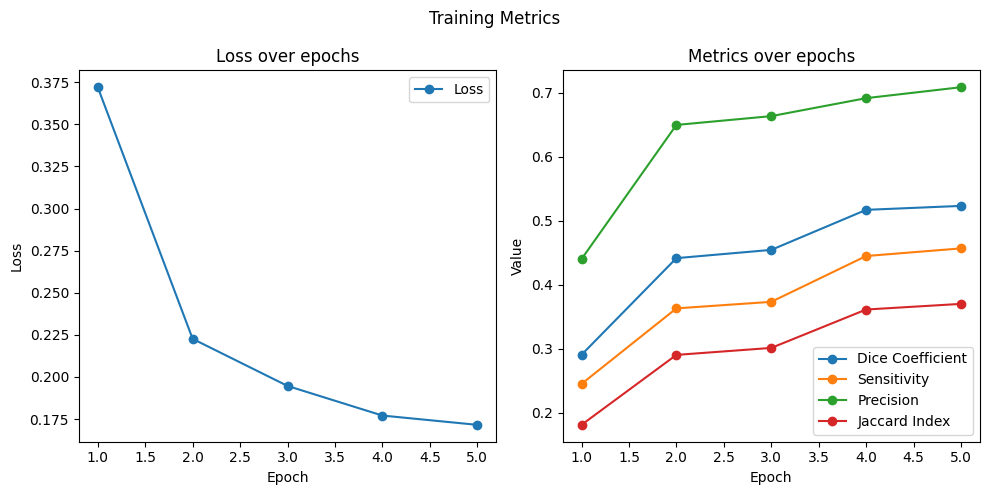

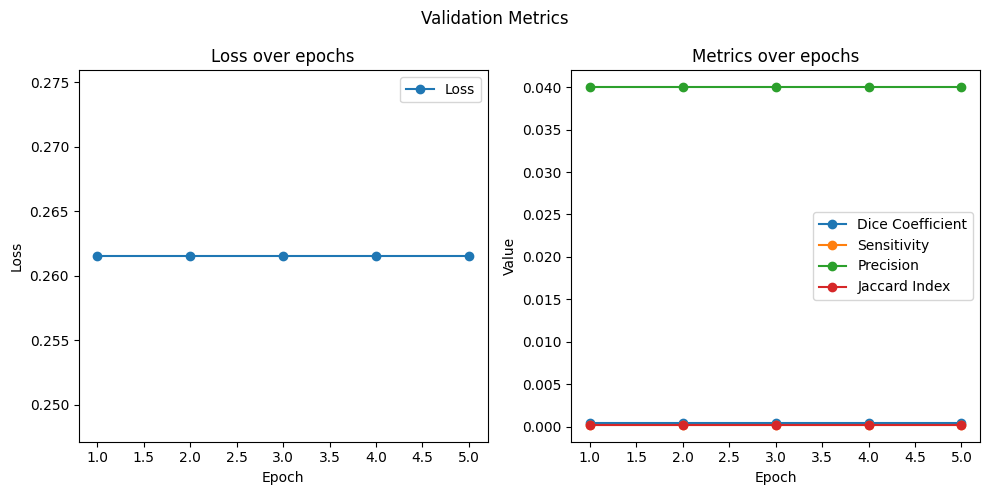

In [122]:
def plot_metrics(losses, metrics, title):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(10, 5))

    # Graficar la pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label='Loss', marker='o')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Graficar las métricas
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics[:, 0], label='Dice Coefficient', marker='o')
    plt.plot(epochs, metrics[:, 1], label='Sensitivity', marker='o')
    plt.plot(epochs, metrics[:, 2], label='Precision', marker='o')
    plt.plot(epochs, metrics[:, 3], label='Jaccard Index', marker='o')
    plt.title('Metrics over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Graficar métricas de entrenamiento
train_losses = [np.mean(loss) for loss in train_losses]
train_metrics = np.array(train_metrics)
plot_metrics(train_losses, train_metrics, title='Training Metrics')

# Graficar métricas de validación
val_losses = [np.mean(loss) for loss in val_losses]
val_metrics = np.array(val_metrics)
plot_metrics(val_losses, val_metrics, title='Validation Metrics')

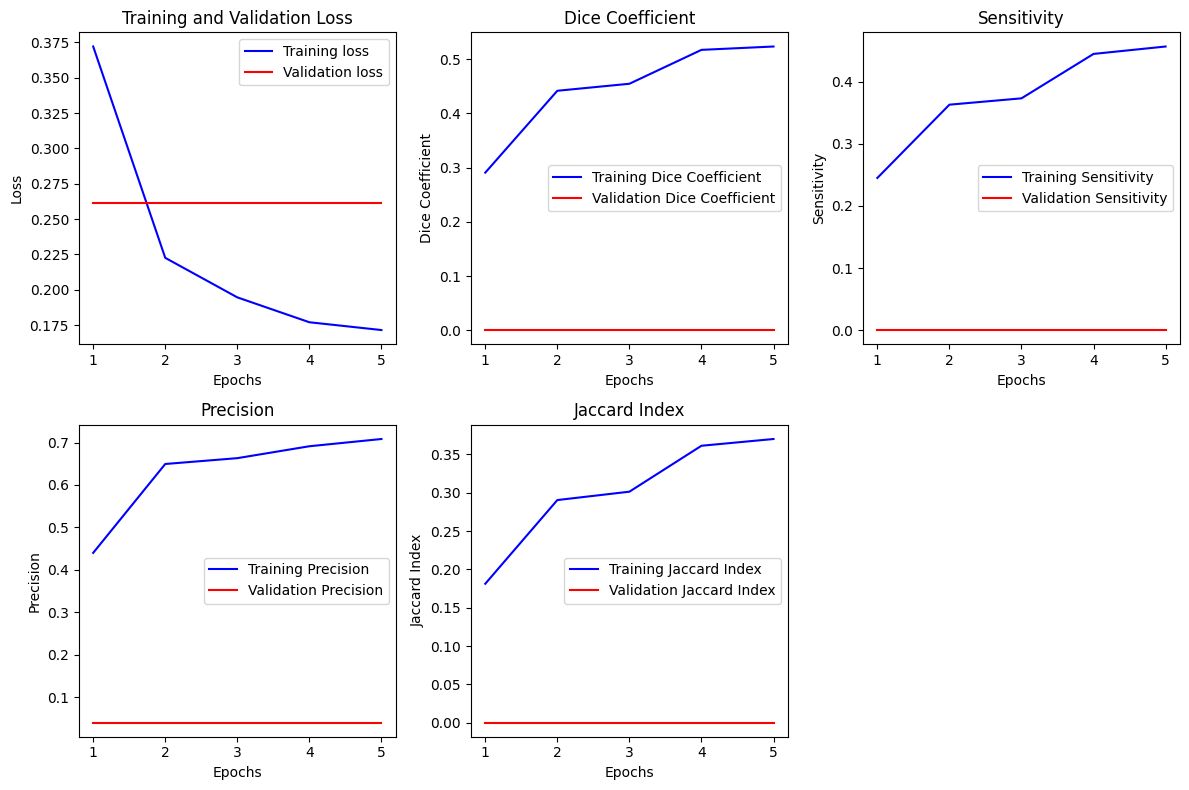

In [123]:
# Función para graficar las métricas y pérdidas
def plot_metrics(train_losses, train_metrics, val_losses, val_metrics):
    epochs = range(1, len(train_losses) + 1)

    # Convertir las métricas de entrenamiento y validación a arrays de numpy para facilitar el acceso
    train_metrics = np.array(train_metrics)
    val_metrics = np.array(val_metrics)

    # Graficar la pérdida
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Graficar el coeficiente de Dice
    plt.subplot(2, 3, 2)
    plt.plot(epochs, train_metrics[:, 0], 'b', label='Training Dice Coefficient')
    plt.plot(epochs, val_metrics[:, 0], 'r', label='Validation Dice Coefficient')
    plt.title('Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    # Graficar la Sensibilidad
    plt.subplot(2, 3, 3)
    plt.plot(epochs, train_metrics[:, 1], 'b', label='Training Sensitivity')
    plt.plot(epochs, val_metrics[:, 1], 'r', label='Validation Sensitivity')
    plt.title('Sensitivity')
    plt.xlabel('Epochs')
    plt.ylabel('Sensitivity')
    plt.legend()

    # Graficar la Precisión
    plt.subplot(2, 3, 4)
    plt.plot(epochs, train_metrics[:, 2], 'b', label='Training Precision')
    plt.plot(epochs, val_metrics[:, 2], 'r', label='Validation Precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Graficar el Índice de Jaccard
    plt.subplot(2, 3, 5)
    plt.plot(epochs, train_metrics[:, 3], 'b', label='Training Jaccard Index')
    plt.plot(epochs, val_metrics[:, 3], 'r', label='Validation Jaccard Index')
    plt.title('Jaccard Index')
    plt.xlabel('Epochs')
    plt.ylabel('Jaccard Index')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Graficar las métricas y pérdidas después del entrenamiento
plot_metrics(train_losses, train_metrics, val_losses, val_metrics)